

```
--- 
title: "Nine-month Salary dataset analysis" 
author: 
 - Guilherme Gonçalves de Lima 
created_at: 2020-03-30 00:00:00 
updated_at: 2020-04-16 00:00:00 
tags: 
 - nationwide interview 
 - modeling 
 - eda 
 - multiple linear regression 
tldr: 
--- 
```





---




# **1 Introduction**

This report provides answers to Modeling exercise as required to [Nationwide](https://www.nationwide.com/) interview. The remainder of this report is organized in the following order. A brief overview of dataset is described in [Section 2](). [Section 3]() presents a quick Exploratory Data Analysis - EDA. In [Section 4](), tasks to be completed.
<br></br>



---



# **2 DataSet**

The data used in this report is the 2008-09 nine-month academic salary for Assistant Professors, Associate Professors and Professors in a college in the U.S. The data were collected as part of the ongoing effort of the college's administration to monitor salary differences between male and female faculty members.

The data set contains 397 rows and 6 variables, described as follows.


Variables | Description
--- | ---
`rank` | A factor with three levels: `AsstProf`, `AssocProf`, `Prof` (Corresponding to Assistant Professor, Associate Professor, and full Professor).
`discipline` | A factor with two levels: `A` ("theoretical" departments), and `B` ("applied" departments).
`yrs.since.phd` | Years since PhD was first received.
`yrs.service` | Years of service.
`sex` | A factor with two levels: `Female` and `Male`.
`salary` | Nine-month salary, in dollars.

<br></br>

## 2.1 Loading data

In [ ]:
!pip install statsmodels==0.11.1

In [ ]:
from google.colab import files

# Upload dataset
uploaded = files.upload()

In [ ]:
# Data analysis and manipulation tools
import numpy as np
import pandas as pd
from itertools import combinations
from sklearn.model_selection import train_test_split

# Data Visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

%matplotlib inline
plt.style.use('fivethirtyeight')
np.set_printoptions(precision=3, suppress=True)

# Statistical models and tests
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats import diagnostic
from statsmodels.stats.stattools import jarque_bera
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.stats import (
    probplot,
    boxcox,
    boxcox_normplot,
    mannwhitneyu,
    chi2_contingency
)
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    accuracy_score,
    classification_report
)
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score
)
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression
)

In [ ]:
# utils

dollar_formatter = ticker.FuncFormatter(lambda t, pos: '$%dk' % (t/1000))
year_formatter = ticker.FuncFormatter(lambda t, pos: ('0yr' if t==0 else '%dyrs' % t))

# Color palettes for charts usage
sex_color_palette = {
    'Female' : '#117733',
    'Male' : '#F1A340',
}

discipline_color_palette = {
    'Applied dept.': '#998EC3',
    'Theoretical dept.': '#F0E441',
}

rank_color_palette = {
    '1 Asst Prof' : '#C59434',
    '2 Assoc Prof' : '#44BB98',
    '3 Prof' : '#A3B7F9',    
}

def custom_histogram(data,
                     x,
                     xlabel=None,
                     layout=(0, 0),
                     loc=(0, 0),
                     f_formatter=None,
                     color_hist='#666666'):
    ''' Custom function to create Histogram plot

        # Arguments
            [TODO]
        # Returns
            ax: matplotlib Axis
    '''
    ax = plt.subplot2grid(shape=layout, loc=loc)
    ax = sns.distplot(data[x], bins=8, hist=True, kde=False, hist_kws={'edgecolor':'#ffffff', 'alpha': .8, 'color': color_hist}, kde_kws={'linewidth': 2})
    ax.grid(axis='both', alpha=.2)
    ax.set_xlabel(xlabel)
    ax.xaxis.set_major_formatter(f_formatter)
    mean = data[x].mean()
    median = data[x].median()
    # [TODO] improve how to get better legends
    if x == 'salary':
        ax.axvline(x=mean, color='r', linestyle='dashdot', lw=2, label='Mean: $%.2fk'%(mean/1000))
        ax.axvline(x=median, color='g', linestyle='dotted', lw=2, label='Median: $%.2fk'%(median/1000))
    elif x in ['yrs_since_phd', 'yrs_service']:
        ax.axvline(x=mean, color='r', linestyle='dashdot', lw=2, label='Mean: %.1fyrs'%(mean))
        ax.axvline(x=median, color='g', linestyle='dotted', lw=2, label='Median: %.1fyrs'%(median))
    ax.legend(fontsize='small')
    return ax

def custom_boxplot(data,
                   x=None,
                   y=None,
                   xlabel='',
                   ylabel='',
                   factor_order=None,
                   color_palette=None,
                   layout=(0, 0),
                   loc=(0, 0),
                   f_formatter=None):
    ''' Function to create Boxplot

        # Arguments
            [TODO]
        # Returns
            ax: matplotlib Axis
    '''
    ax = plt.subplot2grid(shape=layout, loc=loc)
    ax = sns.boxplot(data=data, y=y, x=x, linewidth=1, width=.5, order=factor_order, palette=color_palette)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(f_formatter))
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    # [TODO] improve how to get better xticklabels
    if x=='rank':
        ax.set_xticklabels([t.get_text()[2:] for t in ax.get_xticklabels()])
    return ax

def custom_sort_legend(x):
    ''' Function do order handles and labels for plt usage.

        # Arguments
            x: handles and labels from legend.
        
        # Returns
            handles and labels sorted for legend.
    '''
    handles, labels = x
    # Spliting handles and labels
    h0, h1, l0, l1 = handles[0], handles[1:], labels[0], labels[1:]
    # Sorting handles by labels
    l1, h1 = zip(*sorted(zip(l1, h1), key=lambda pair: pair[0]))
    # Concatenate list
    handles, labels = [h0] + list(h1), [l0] + list(l1)
    return handles, labels

def custom_scatterplot(data,
                       x=None,
                       y=None,
                       hue=None,
                       xlabel='',
                       ylabel='',
                       layout=(0, 0),
                       loc=(0, 0),
                       color_palette=None,
                       f_formatter=None):
    ''' Function to create Boxplot

        # Arguments
            [TODO]
        # Returns
            ax: matplotlib Axis
    '''

    ax = plt.subplot2grid(shape=layout, loc=loc)
    ax = sns.scatterplot(data=salaries, y=y, x=x, hue=hue, linewidth=1, palette=color_palette, s=70, alpha=.8)
    ax.yaxis.set_major_formatter(f_formatter)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    handles, labels = custom_sort_legend(ax.get_legend_handles_labels())
    ax.legend(handles, labels)
    return ax

def cramers_corr(x, y):
    ''' Function to calculate Cramer's V statistic using bias correction
        for categorical variables.

        Cramér's V varies from 0 to 1:
            0: no association between the variables;
            1: complete association.
        
        Interpretation:
            >.25: very strong
            >.15: strong
            >.10: moderate
            >.05: weak

        # Arguments
            x: values of categorical variable (pandas.Series type).
            y: values of categorical variable (pandas.Series type).

        # Returns
            Cramer's V statistic
        
        # References
            Bergsma, Wicher (2013). "A bias correction for Cramér's V and Tschuprow's T". Journal of the Korean Statistical Society. 42 (3): 323–328.
    '''
    # Confusion matrix
    cm = pd.crosstab(x, y)
    # Pearson's chi-squared test statistic
    chi2 = chi2_contingency(cm)[0]
    # # observation, # rows, # columns
    n, r, k = cm.sum().sum(), cm.shape[0], cm.shape[1]
    # phi coefficient
    phi2 = chi2/n
    # Bias correction
    phi2_bias_correction = max(0, phi2 - (((k-1)*(r-1))/(n-1)))    
    r_bias_correction = r - (((r-1)**2)/(n-1))
    k_bias_correction = k - (((k-1)**2)/(n-1))

    return np.sqrt(phi2_bias_correction/min((r_bias_correction-1), (k_bias_correction-1)))

def custom_normality_test(x):
    ''' Function to test for normality using Jarque-Bera test

        # Arguments:
            x: data to test for normality
        # Returns:
            Dict with statistics.
    '''
    norm_test_labels = ['jb_stat', 'jb_pvalue', 'skew', 'kurtosis']
    result = dict(zip(
        norm_test_labels,
        np.round(jarque_bera(x), 6)
    ))
    return result

def custom_resid_tests(model, title=''):
    ''' Residual tests: Normality, Independence, Homoscedasticity
        
        # Arguments
            model: model isntance
        # Returns
            Print Test Results
    '''
    print(title)
    print('Formula: %s' % model.model.formula)
    print('\nResidual Tests\n---')
    # Jarque-Bera test: Normality in residuals.
    print('Normality: Jarque-Bera test')
    norm_test_labels = ['jb_stat', 'jb_pvalue', 'skew', 'kurtosis']
    print(dict(zip(norm_test_labels, np.round(jarque_bera(model.wresid), 5))))
    print('---')
    # Ljung-Box test of autocorrelation in residuals.
    print('Independence: Ljung-Box test')
    print(diagnostic.acorr_ljungbox(x=model.resid, lags=1, return_df=True).to_dict('records')[0])
    print('---')
    # Bresch-Pagan test of residuals Homoscedasticity
    het_test_labels = ['LM_stat', 'LM_pvalue', 'F_stat', 'F_pvalue']
    print('Homoscedasticity: Breusch-Pagan test')
    print(dict(zip(het_test_labels, np.round(diagnostic.het_breuschpagan(model.resid, model.model.exog), 5))))

def custom_resid_fit_plot(model, layout=(0, 0), loc=(0, 0), transf=False):
    ''' Custom Standardized Residuals vs Fitted plot.

        # Arguments
            [TODO]
        # Returns
            ax: matplotlib Axis
    '''
    residuals = model.get_influence().resid_studentized_internal
    fitted = model.fittedvalues
    smoothed = lowess(residuals, fitted.values, frac=.7)
    ax = plt.subplot2grid(shape=layout, loc=loc)
    ax.scatter(fitted, residuals, facecolors='#666666', alpha=.5)
    ax.plot(smoothed[:,0],smoothed[:,1], color = 'r', lw=2)
    if not transf:
        axis_formatter = ticker.FuncFormatter(lambda t, pos: '%dk' % (t/1000))
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(axis_formatter))
    ax.grid(axis='both', alpha=.4)
    ax.set_ylabel('Standardized Residuals')
    ax.set_xlabel('Fitted Values')
    ax.set_title('Standardized Residuals vs. Fitted', fontdict={'fontsize': 16})
    ax.axhline(y=0, color='#666666', ls='--', lw=1)
    return ax

def custom_resid_qqplot(model, layout=(0, 0), loc=(0, 0)):
    ''' Custom Normal Quantile-Quantile plot

        # Arguments:
            [TODO]
        # Returns
            ax: matplotlib Axis
    '''
    student_resid = sorted(model.get_influence().resid_studentized_internal)
    theoretical_quantiles = probplot(x=student_resid, dist='norm', fit=False)[0]
    ax = plt.subplot2grid(shape=layout, loc=loc)
    ax.scatter(x=theoretical_quantiles, y=student_resid, facecolor='#666666', alpha=.5)
    ax.set_ylabel('Standardized Residuals')
    ax.set_xlabel('Theoretical Quantiles')
    ax.set_title('Normal Q-Q', fontdict={'fontsize': 16})
    ax.plot(
        [np.min([theoretical_quantiles, student_resid]), np.max([theoretical_quantiles, student_resid])],
        [np.min([theoretical_quantiles, student_resid]), np.max([theoretical_quantiles, student_resid])],
        'r--', lw=1
    )
    ax.grid(axis='both', alpha=.4)
    return ax

def custom_resid_hist(model, layout=(0, 0), loc=(0, 0)):
    ''' Custom function to create Residual Histogram plot

        # Arguments
            [TODO]
        # Returns
            ax: matplotlib Axis
    '''
    ax = plt.subplot2grid(shape=layout, loc=loc)
    ax = sns.distplot(model.get_influence().resid_studentized_internal,
                      bins=8, hist=True, kde=True, norm_hist=True, 
                      hist_kws={'edgecolor':'#ffffff', 'alpha': .8, 'color': '#666666', 'label': 'hist'},
                      kde_kws={'linewidth': 2, 'color': '#0f4c81', 'label': 'kde'})
    ax.grid(axis='both', alpha=.4)
    ax.set_xlabel('Standardized Residuals')
    ax.set_title('Standardized Residuals Histogram', fontdict={'fontsize': 16})
    ax.legend(fontsize='small')
    return ax

def custom_residual_plots(model, figsize=(18, 8), transf=False):
    ''' Custom Residuals Diagnostic plots

        # Arguments
            [TODO]
        # Returns
            fig: matplotlib Figure
            ax: matplotlib Axis
    '''
    fig, ax = plt.subplots(figsize=figsize)
    fig_layout = (1, 3)
    ax1 = custom_resid_fit_plot(model=model, layout=fig_layout, loc=(0, 0), transf=transf)
    ax2 = custom_resid_qqplot(model=model, layout=fig_layout, loc=(0, 1))
    ax3 = custom_resid_hist(model=model, layout=fig_layout, loc=(0, 2))
    return fig, ax

In [ ]:
# Loading dataset
salaries = pd.read_csv('./data/Salaries.csv')

# Verify columns names
salaries.columns

Index(['rank', 'discipline', 'yrs.since.phd', 'yrs.service', 'sex', 'salary'], dtype='object')

## 2.2 Data cleaning

In [ ]:
# Rename columns
salaries.columns = salaries.columns.str.replace(pat='.', repl='_')
salaries.columns

Index(['rank', 'discipline', 'yrs_since_phd', 'yrs_service', 'sex', 'salary'], dtype='object')

### Dataset concise summary
---
This dataset contains 3 Continuous Variables and 3 Categorical Variables (Ordinal and Nominal). There is no missing values.
<br></br>

In [ ]:
# A concise summary of dataset
print('%15s  %-6s  %-6s  %s' % ('Column', 'Dtype', 'NA', 'Values'))
print('%15s  %-6s  %-6s  %s' % ('------', '-----', '--', '------'))
for key, values in salaries.dtypes.items():
    print('%15s  %-6s  %d null  %s' % (key,
                                       values,
                                       salaries[key].isnull().sum(),
                                       salaries[key].values[:6])
    )

         Column  Dtype   NA      Values
         ------  -----   --      ------
           rank  object  0 null  ['Prof' 'Prof' 'AsstProf' 'Prof' 'Prof' 'AssocProf']
     discipline  object  0 null  ['B' 'B' 'B' 'B' 'B' 'B']
  yrs_since_phd  int64   0 null  [19 20  4 45 40  6]
    yrs_service  int64   0 null  [18 16  3 39 41  6]
            sex  object  0 null  ['Male' 'Male' 'Male' 'Male' 'Male' 'Male']
         salary  int64   0 null  [139750 173200  79750 115000 141500  97000]


### Categorical variables
---
Categorical variables requires transformation to better understanding during report code.
<br></br>

In [ ]:
# Seeing Factors
print('%15s  %s' % ('Column', 'Factors'))
print('%15s  %s' % ('------', '-------'))
for key in salaries.select_dtypes(include='object'):
    print('%15s  %s' % (key, salaries[key].sort_values().unique()))

         Column  Factors
         ------  -------
           rank  ['AssocProf' 'AsstProf' 'Prof']
     discipline  ['A' 'B']
            sex  ['Female' 'Male']


In [ ]:
# rank is an Ordinal Variable 
# reference: [https://en.wikipedia.org/wiki/Academic_ranks_in_the_United_States]
# Tranforming factors to logical order.
rank_factors = {
    'AsstProf': '1 Asst Prof',
    'AssocProf': '2 Assoc Prof',
    'Prof': '3 Prof',
}
salaries.replace(to_replace=rank_factors, inplace=True)

# discipline is a Nominal Variable
#     A: "theoretical" departments
#     B: "applied" departments
discipline_factors = {
    'A': 'Theoretical dept.',
    'B': 'Applied dept.',
}
salaries.replace(to_replace=discipline_factors, inplace=True)

# Factors of string columns
print('%15s  %s' % ('Column', 'Factors'))
print('%15s  %s' % ('------', '-------'))
for key in salaries.select_dtypes(include='object'):
    print('%15s  %s' % (key, salaries[key].sort_values().unique()))

# Factors variables for charts usage
rank_factors = ['1 Asst Prof', '2 Assoc Prof', '3 Prof']
discipline_factors = ['Applied dept.', 'Theoretical dept.']
sex_factors = ['Female', 'Male']

         Column  Factors
         ------  -------
           rank  ['1 Asst Prof' '2 Assoc Prof' '3 Prof']
     discipline  ['Applied dept.' 'Theoretical dept.']
            sex  ['Female' 'Male']




---



# **3 EDA**

This section presents a quick Exploratory Data Analysis, we will analyze variables individually and the realtionship with other variables to understand the dataset and provide insights to tasks to be completed.

### Table of Rank
---

Full Professors is 67.00% (266) of observations, followed by Assistant Professors with 16.88% (67) and Associate Professors with 16.12% (64).

In [ ]:
# rank factors:
#     '1_Asst_Prof': Assistant Professors
#     '2_Assoc_Prof': Associate Professors
#     '3_Prof': Professors
pd.concat(
    [
        salaries['rank'].value_counts(),
        salaries['rank'].value_counts(normalize=True).mul(100).round(2),
        salaries.groupby('rank')['salary'].mean().div(1000).round(2),
        salaries.groupby('rank')['salary'].median().div(1000).round(2)
    ],
    axis=1, names='rank', keys=('Counts', 'Percentage', 'Salary mean ($k)', 'Salary median ($k)'), sort=True
)

rank,Counts,Percentage,Salary mean ($k),Salary median ($k)
1 Asst Prof,67,16.88,80.78,79.80
2 Assoc Prof,64,16.12,93.88,95.63
3 Prof,266,67.00,126.77,123.32


### Table of Discipline
--- 

Professors working under Applied and Theoretical Departments are, respectively, 54.41% (216) and 45.59%(181).

In [ ]:
# discipline factors:
#     A: "theoretical" departments
#     B: "applied" departments
pd.concat(
    [
        salaries['discipline'].value_counts(),
        salaries['discipline'].value_counts(normalize=True).mul(100).round(2),
        salaries.groupby('discipline')['salary'].mean().div(1000).round(2),
        salaries.groupby('discipline')['salary'].median().div(1000).round(2)
    ],
    axis=1, names='', keys=('Counts', 'Percentage', 'Salary mean ($k)', 'Salary median ($k)'), sort=True
)

,Counts,Percentage,Salary mean ($k),Salary median ($k)
discipline,,,,
Applied dept.,216,54.41,118.03,113.02
Theoretical dept.,181,45.59,108.55,104.35


### Table of Sex
---

There are more male Professors, 90.18% (358), compared to female, 9.82% (39).

In [ ]:
# sex factors:
#     Female
#     Male
pd.concat(
    [
        salaries['sex'].value_counts(),
        salaries['sex'].value_counts(normalize=True).mul(100).round(2),
        salaries.groupby('sex')['salary'].mean().div(1000).round(2),
        salaries.groupby('sex')['salary'].median().div(1000).round(2)
    ],
    axis=1, names='', keys=('Counts', 'Percentage', 'Salary mean ($k)', 'Salary median ($k)'), sort=True
)

,Counts,Percentage,Salary mean ($k),Salary median ($k)
Female,39,9.82,101.00,103.75
Male,358,90.18,115.09,108.04


### Boxplots of Years since PhD, Years of Service, and Salary
---
The boxplots suggests that there is outliers in Years of Service and Salary variables.

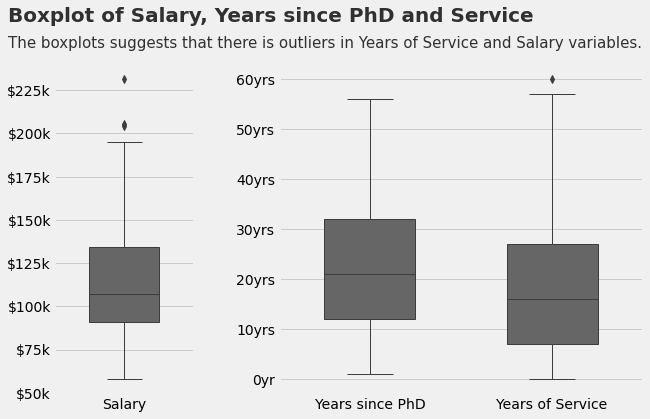

In [ ]:
# Setting size
fig, ax = plt.subplots(figsize=(10, 6))
fig_layout = (1, 3)
# Boxplot years since PhD, years of service
ax1 = plt.subplot2grid(shape=fig_layout, loc=(0, 1), colspan=2)
ax1 = sns.boxplot(data=salaries[['yrs_since_phd', 'yrs_service']], linewidth=1, width=.5, color='#666666')
ax1.set_xticklabels(['Years since PhD', 'Years of Service'])
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '0yr' if x==0 else '%dyrs' % x))
# Boxplot Salary
ax2 = plt.subplot2grid(shape=fig_layout, loc=(0, 0))
ax2 = sns.boxplot(data=salaries[['salary']], linewidth=1, width=.5, color='#666666')
ax2.set_xticklabels(['Salary'])
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '$%dk' % (x/1000)))
# Title
plt.gcf().text(0.06, 1, 'Boxplot of Salary, Years since PhD and Service', fontsize=20, weight='bold', alpha=.8)
plt.gcf().text(0.06, .94, 'The boxplots suggests that there is outliers in Years of Service and Salary variables.', fontsize=15, alpha=.8)
plt.tight_layout(pad=3)

### Histogram of Years since PhD, Years of Service and Salary
---
The variables Years since PhD, Years of Service and Salary are slightly positive-skewed distributions.

The Years of Service seems to be exponentially distributed.

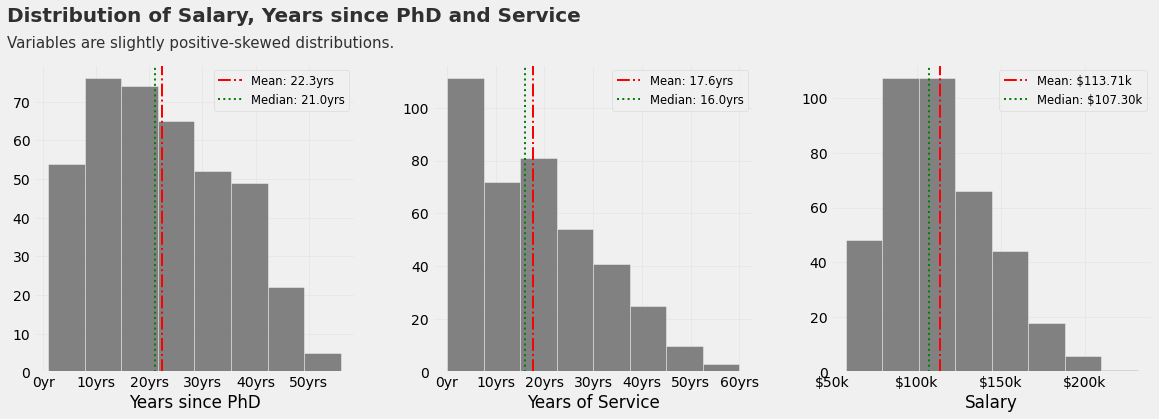

In [ ]:
# Setting size
fig, ax = plt.subplots(figsize=(17, 6))
fig_layout = (1, 3)
# Histogram years since PhD
ax1 = custom_histogram(data=salaries, x='yrs_since_phd', xlabel='Years since PhD', layout=fig_layout, loc=(0, 0), f_formatter=year_formatter)
# Histogram of years of service
ax2 = custom_histogram(data=salaries, x='yrs_service', xlabel='Years of Service', layout=fig_layout, loc=(0, 1), f_formatter=year_formatter)
# Histogram of salary
ax3 = custom_histogram(data=salaries, x='salary', xlabel='Salary', layout=fig_layout, loc=(0, 2), f_formatter=dollar_formatter)
# Title
plt.gcf().text(0.03, 1, 'Distribution of Salary, Years since PhD and Service', fontsize=20, weight='bold', alpha=.8)
plt.gcf().text(0.03, .94, 'Variables are slightly positive-skewed distributions.', fontsize=15, alpha=.8)
plt.tight_layout(pad=3)

### Outliers
---
Analysing detected outliers, it does not seems it was a data input error.
 
For Salary variable, the difference between top-10 salaries does not seems discrepant.
 
Based on these few values, these professors may have some condition to receive higher salaries.
 
For Years of Service, the outlier value is 60yrs, but Years since PhD is higher too, 49yrs. So, it seems ok.
 
However, for the first analysis, these values will not be removed or be treated.

In [ ]:
# Detect outliers (Univariate) using Interquartile Range - IQR
# Continuous variables
salaries_continuous = salaries[['yrs_service', 'salary']]

# Quartiles and Interquartile Range
Q1 = salaries_continuous.quantile(0.25)
Q3 = salaries_continuous.quantile(0.75)
IQR = Q3 - Q1

# Outliers by IQR
salaries_outliers = (salaries_continuous < (Q1-(IQR*1.5))) | (salaries_continuous > (Q3+(IQR*1.5)))
salaries_outliers = salaries_outliers[salaries_outliers.sum(axis=1) == 1]
salaries_outliers

,yrs_service,salary
43,False,True
249,False,True
330,True,False
364,False,True


In [ ]:
# Vizualize row of Detected Outliers
salaries.filter(items=salaries_outliers.index, axis=0)

,rank,discipline,yrs_since_phd,yrs_service,sex,salary
43,3 Prof,Applied dept.,38,38,Male,231545
249,3 Prof,Theoretical dept.,29,7,Male,204000
330,3 Prof,Applied dept.,49,60,Male,192253
364,3 Prof,Theoretical dept.,43,43,Male,205500


In [ ]:
print( 'Top 10 Salaries: %s' % ['$%dk' % (s/1000) for s in sorted(salaries.salary.values)[-10:]])

Top 10 Salaries: ['$183k', '$186k', '$186k', '$189k', '$192k', '$193k', '$194k', '$204k', '$205k', '$231k']


### Boxplots of Salary by Sex, Discipline and Rank
---

The boxplots indicates that Male has higher salaries (\~50\% with more than \$100k) than Female professors (\~50\% with less than \$100k). 

Applied departments has higher salaries (\~75\% with more than \$100k) than Theoretical departments (\~50\% with less than \$100k). 

It describes a clear difference between professor rank when comparing Salaries. In average, Full Professors has higher salaries (\~75\% with more than \$100k), followed by Associate Professors (\~50\% with more than \$100k) and Assistant Professors (all with less than \$100k).

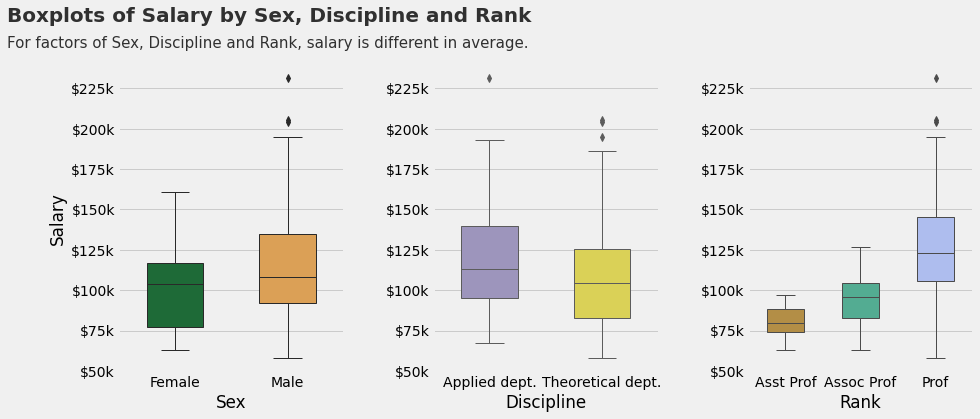

In [ ]:
# Setting size
fig, ax = plt.subplots(figsize=(14, 6))
fig_layout = (1, 3)
# Boxplot salary by sex, discipline, rank
ax1 = custom_boxplot(data=salaries, x='sex', y='salary',  xlabel='Sex', ylabel='Salary', factor_order=sex_factors, color_palette=sex_color_palette, layout=fig_layout, loc=(0, 0), f_formatter=dollar_formatter)
ax2 = custom_boxplot(data=salaries, x='discipline', y='salary',  xlabel='Discipline', ylabel='', factor_order=discipline_factors, color_palette=discipline_color_palette, layout=fig_layout, loc=(0, 1), f_formatter=dollar_formatter)
ax3 = custom_boxplot(data=salaries, x='rank', y='salary',  xlabel='Rank', ylabel='', factor_order=rank_factors, color_palette=rank_color_palette, layout=fig_layout, loc=(0, 2), f_formatter=dollar_formatter)
# Title
plt.gcf().text(0, 1, 'Boxplots of Salary by Sex, Discipline and Rank', fontsize=20, weight='bold', alpha=.8)
plt.gcf().text(0, .94, 'For factors of Sex, Discipline and Rank, salary is different in average.', fontsize=15, alpha=.8)
plt.tight_layout(pad=3)

### Boxplots of Years since PhD by Sex, Discipline and Rank
---

The boxplots shows that Male has more Years since PhD (\~50\% with more than 20yrs) than Female professors (\~50\% with less than 20yrs).

Theoretical departments has more Years since PhD (\~50\% with more than 30yrs) than Applied departments (\~75\% with less than 30yrs).

Full Professors has more Years since PhD (\~75\% with more than 20yrs), followed by Associate Professors (\~75\% with more than 10yrs) and Assistant Professors (\~75\% with less than 10yrs).

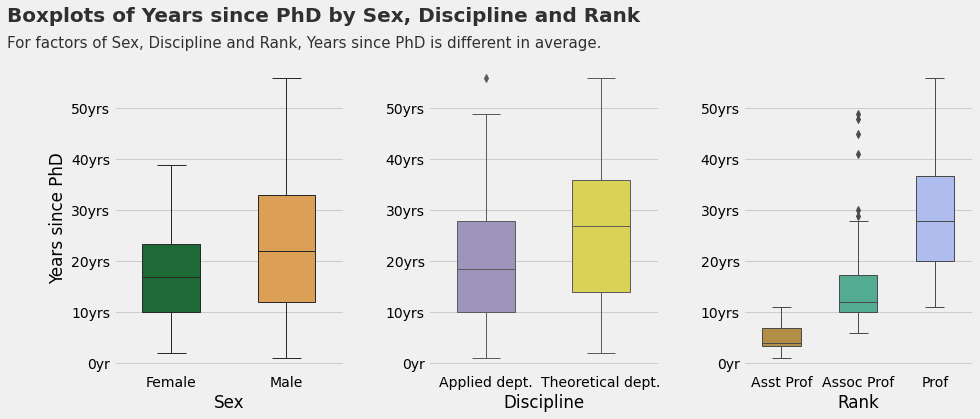

In [ ]:
# Setting size
fig, ax = plt.subplots(figsize=(14, 6))
fig_layout = (1, 3)
# Boxplot years since PhD by sex, discipline, rank
ax1 = custom_boxplot(data=salaries, x='sex', y='yrs_since_phd',  xlabel='Sex', ylabel='Years since PhD', factor_order=sex_factors, color_palette=sex_color_palette, layout=fig_layout, loc=(0, 0), f_formatter=year_formatter)
ax2 = custom_boxplot(data=salaries, x='discipline', y='yrs_since_phd',  xlabel='Discipline', ylabel='', factor_order=discipline_factors, color_palette=discipline_color_palette, layout=fig_layout, loc=(0, 1), f_formatter=year_formatter)
ax3 = custom_boxplot(data=salaries, x='rank', y='yrs_since_phd',  xlabel='Rank', ylabel='', factor_order=rank_factors, color_palette=rank_color_palette, layout=fig_layout, loc=(0, 2), f_formatter=year_formatter)
# Title
plt.gcf().text(0, 1, 'Boxplots of Years since PhD by Sex, Discipline and Rank', fontsize=20, weight='bold', alpha=.8)
plt.gcf().text(0, .94, 'For factors of Sex, Discipline and Rank, Years since PhD is different in average.', fontsize=15, alpha=.8)
plt.tight_layout(pad=3)

### Boxplots of Years of Service by Sex, Discipline and Rank
---

The boxplots suggests that Male has more Years of Service (\~50\% with more than 20yrs) than Female professors (\~75\% with less than 20yrs).

Theoretical departments has more Years of Service (\~50\% with more than 20yrs) than Applied departments (\~75\% with less than 20yrs).

Full Professor has more Years of Service (\~50\% with more than 20yrs), followed by Associate Professors (\~75\% with more than 5yrs) and Assistant Professors (\~90% with less than 5yrs).

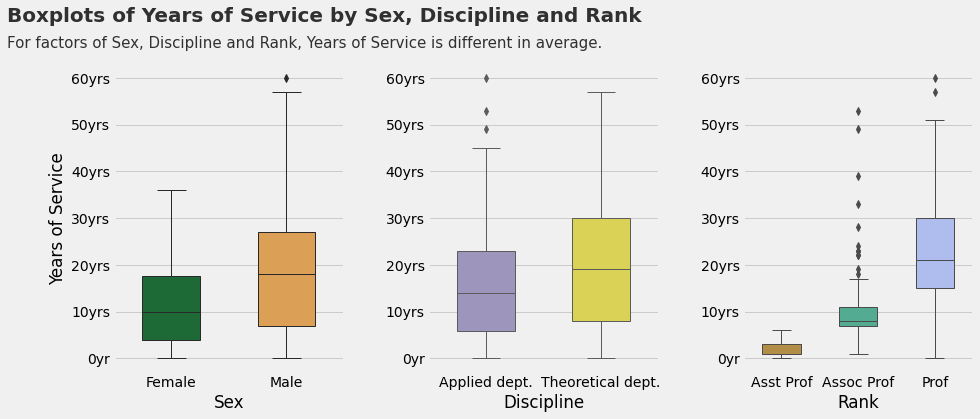

In [ ]:
# Setting size
fig, ax = plt.subplots(figsize=(14, 6))
fig_layout = (1, 3)
# Boxplot years of Service by sex, discipline, rank
ax1 = custom_boxplot(data=salaries, x='sex', y='yrs_service',  xlabel='Sex', ylabel='Years of Service', factor_order=sex_factors, color_palette=sex_color_palette, layout=fig_layout, loc=(0, 0), f_formatter=year_formatter)
ax2 = custom_boxplot(data=salaries, x='discipline', y='yrs_service',  xlabel='Discipline', ylabel='', factor_order=discipline_factors, color_palette=discipline_color_palette, layout=fig_layout, loc=(0, 1), f_formatter=year_formatter)
ax3 = custom_boxplot(data=salaries, x='rank', y='yrs_service',  xlabel='Rank', ylabel='', factor_order=rank_factors, color_palette=rank_color_palette, layout=fig_layout, loc=(0, 2), f_formatter=year_formatter)
# Title
plt.gcf().text(0, 1, 'Boxplots of Years of Service by Sex, Discipline and Rank', fontsize=20, weight='bold', alpha=.8)
plt.gcf().text(0, .94, 'For factors of Sex, Discipline and Rank, Years of Service is different in average.', fontsize=15, alpha=.8)
plt.tight_layout(pad=3)

### Scatter plot of Salary and Years since PhD grouped by Sex, Rank, Discipline
---

When Years since PhD increases, for some professors Salary increases as well. However, this relationship does not appear extremely strong after 20yrs. For Sex, it does not show a clear difference. It shows when increases Salary and Years since PhD, the rank variables has a clear difference. For Discipline, it shows that even increasing Years since PhD, salary is lower to Theoretical departments comparing to Applied departments.

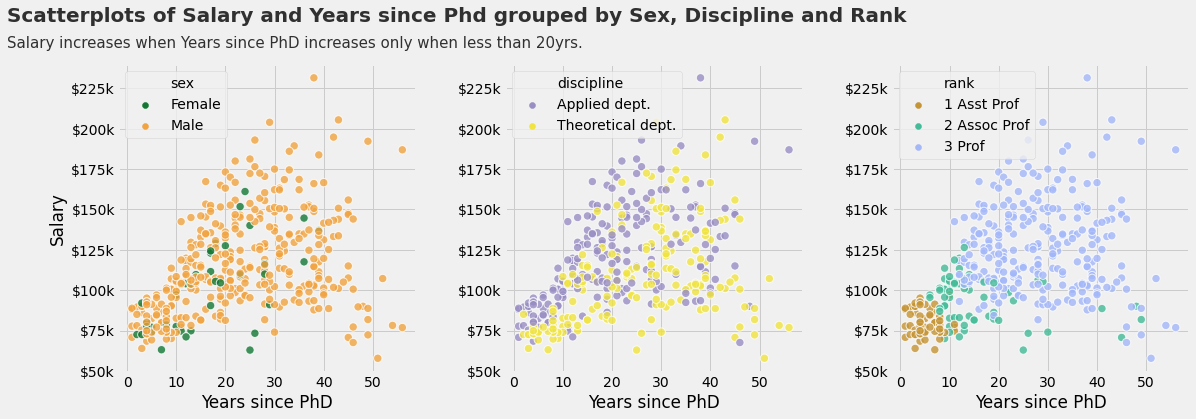

In [ ]:
# Setting size
fig, ax = plt.subplots(figsize=(17, 6))
fig_layout = (1, 3)
# Scatterplot salary by years since PhD, sex, rank, discipline
ax1 = custom_scatterplot(data=salaries, x='yrs_since_phd', y='salary', hue='sex', xlabel='Years since PhD', ylabel='Salary', layout=fig_layout, loc=(0, 0), color_palette=sex_color_palette, f_formatter=dollar_formatter)
ax2 = custom_scatterplot(data=salaries, x='yrs_since_phd', y='salary', hue='discipline', xlabel='Years since PhD', ylabel='', layout=fig_layout, loc=(0, 1), color_palette=discipline_color_palette, f_formatter=dollar_formatter)
ax3 = custom_scatterplot(data=salaries, x='yrs_since_phd', y='salary', hue='rank', xlabel='Years since PhD', ylabel='', layout=fig_layout, loc=(0, 2), color_palette=rank_color_palette, f_formatter=dollar_formatter)
# Title
plt.gcf().text(0, 1, 'Scatterplots of Salary and Years since Phd grouped by Sex, Discipline and Rank', fontsize=20, weight='bold', alpha=.8)
plt.gcf().text(0, .94, 'Salary increases when Years since PhD increases only when less than 20yrs.', fontsize=15, alpha=.8)
plt.tight_layout(pad=3)

### Scatter plot of Salary and Years of Service grouped by Sex, Rank, Discipline
---
 
There does not appear a strong relationship between Salary and Years of Service. It does not shows a clear difference between Sex as well. For Rank, it shows a difference between its factors as expected. For Discipline, Applied departments has higher salary than Theoretical departments even when. Years of Service increases.

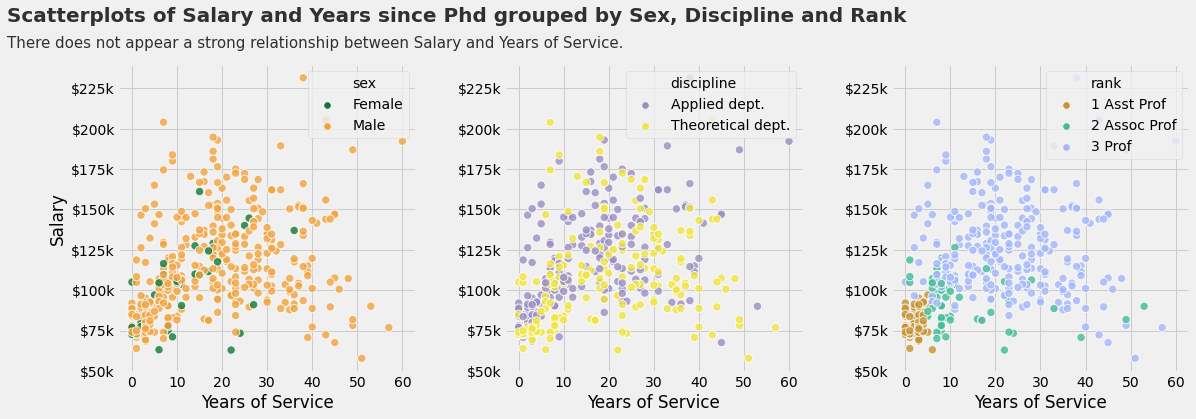

In [ ]:
# Setting size
fig, ax = plt.subplots(figsize=(17, 6))
fig_layout = (1, 3)
# Scatterplot salary by years of service, sex, rank, discipline
ax1 = custom_scatterplot(data=salaries, x='yrs_service', y='salary', hue='sex', xlabel='Years of Service', ylabel='Salary', layout=fig_layout, loc=(0, 0), color_palette=sex_color_palette, f_formatter=dollar_formatter)
ax2 = custom_scatterplot(data=salaries, x='yrs_service', y='salary', hue='discipline', xlabel='Years of Service', ylabel='', layout=fig_layout, loc=(0, 1), color_palette=discipline_color_palette, f_formatter=dollar_formatter)
ax3 = custom_scatterplot(data=salaries, x='yrs_service', y='salary', hue='rank', xlabel='Years of Service', ylabel='', layout=fig_layout, loc=(0, 2), color_palette=rank_color_palette, f_formatter=dollar_formatter)
# Title
plt.gcf().text(0, 1, 'Scatterplots of Salary and Years since Phd grouped by Sex, Discipline and Rank', fontsize=20, weight='bold', alpha=.8)
plt.gcf().text(0, .94, 'There does not appear a strong relationship between Salary and Years of Service.', fontsize=15, alpha=.8)
plt.tight_layout(pad=3)

### Correlation Continuous Variables - Pearson's correlation
---

Salary is moderately correlated with Years since PhD (.42), and weakly correlated with Years of Service (.33).
 
Years of Service and Years since PhD are very strongly correlated (.91) as expected. So, for modeling, we can keep Years since PhD based on this results.

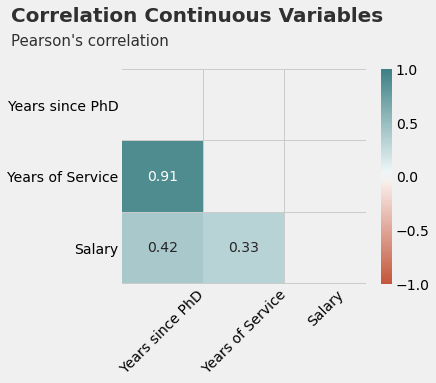

In [ ]:
# Pairwise Pearson's correlation matrix
# Strength of correlation :
#    .00-.19 “very weak”
#    .20-.39 “weak”
#    .40-.59 “moderate”
#    .60-.79 “strong”
#    .80-1.0 “very strong”
salaries_corr = salaries.corr(method='pearson')

# Mask for Correlation Matrix plot
mask = np.zeros_like(salaries_corr)
mask[np.triu_indices_from(mask)] = True

# Columns labels dict
columns_labels_dict = {
    'yrs_since_phd': 'Years since PhD',
    'yrs_service': 'Years of Service',
    'salary': 'Salary',
}

# Plot
fig, ax = plt.subplots(figsize=(7, 5.5))
ax = sns.heatmap(salaries_corr, 
                 xticklabels=[columns_labels_dict[c] for c in salaries_corr.columns.values], 
                 yticklabels=[columns_labels_dict[c] for c in salaries_corr.columns.values],
                 cmap=sns.diverging_palette(20, 200, sep=10, as_cmap=True),
                 center=0, vmin=-1, vmax=1, mask=mask, linewidths=.01, linecolor='#cbcbcb', 
                 annot=True)
plt.xticks(rotation=45)
# Title
plt.gcf().text(0.09, 1, 'Correlation Continuous Variables', fontsize=20, weight='bold', alpha=.8)
plt.gcf().text(0.09, .94, "Pearson's correlation", fontsize=15, alpha=.8)
plt.tight_layout(pad=3)

### Correlation Categorical Variables - Cramer's V
---

Sex and Rank are moderately correlated (.13). Discipline are weekly correlated with Rank (.082) and no correlated with Sex.

For modeling, it seems important keep these variables and testing their significance.

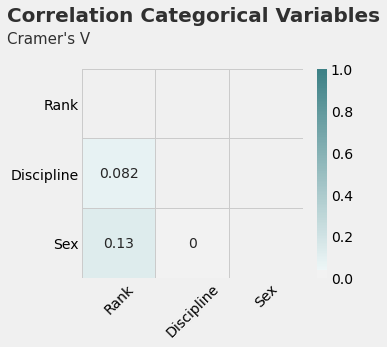

In [ ]:
# Categorical variables
categ_columns = ['rank', 'discipline', 'sex']

# TODO: improve it
# Dict of values for classmethod pd.DataFrame.from_dict
d = {c: {c: 0 for c in categ_columns} for c in categ_columns}
# Combinations for Cramer's V
l = list(combinations(categ_columns, 2))
# Calculate Cramer's V
for a, b in l:
    d[a][b] = cramers_corr(salaries[a], salaries[b])
# DataFrame
categ_corr = pd.DataFrame.from_dict(d)

# Mask for Correlation Matrix plot
mask = np.zeros_like(categ_corr)
mask[np.triu_indices_from(mask)] = True

# Columns labels dict
columns_labels_dict = {
    'rank': 'Rank',
    'discipline': 'Discipline',
    'sex': 'Sex',
}

# Plot
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.heatmap(categ_corr, 
                 xticklabels=[columns_labels_dict[c] for c in categ_corr.columns.values], 
                 yticklabels=[columns_labels_dict[c] for c in categ_corr.columns.values],
                 cmap=sns.diverging_palette(20, 200, sep=10, as_cmap=True),
                 center=0, vmin=0, vmax=1, mask=mask, linewidths=.01, linecolor='#cbcbcb', 
                 annot=True)
plt.yticks(rotation=0)
plt.xticks(rotation=45)
# Title
plt.gcf().text(0.09, 1, 'Correlation Categorical Variables', fontsize=20, weight='bold', alpha=.8)
plt.gcf().text(0.09, .94, "Cramer's V", fontsize=15, alpha=.8)
plt.tight_layout(pad=3)



---



# **4 Tasks to Be Completed**

## **4.1 Analysis**

Answer the following research questions to the best of your ability. Be prepared to walk the interview panel through your code and your thought process.




---



### **(1) What percentage of records are Assistant Professors with less than 5 years of experience?**

---

Considering Years of Service as years of experience, the percentage of records are Assistant Professors with less than 5 years of experience is 15.87%.
<br></br>

In [ ]:
# Creating variable `yrs_service_5`: if professor is less than 5 years of experience (yrs_service)
salaries['yrs_service_5'] = salaries.yrs_service.apply(lambda x: '< 5 yrs' if x < 5 else ' 5+ yrs')

In [ ]:
(salaries[['rank', 'yrs_service_5']]
 .pivot_table(index='rank', columns='yrs_service_5', aggfunc=len)
)

yrs_service_5,5+ yrs,< 5 yrs
rank,,
1 Asst Prof,4,63
2 Assoc Prof,61,3
3 Prof,258,8


In [ ]:
print('Assist Prof with less than 5yrs of experience:') 
print('\n  - %.2f%% of total Assist. Professors'% (100*63/(63+4)))
print('\n  - %.2f%% of total records.\n'% (100*63/(397)))

Assist Prof with less than 5yrs of experience:

  - 94.03% of total Assist. Professors

  - 15.87% of total records.



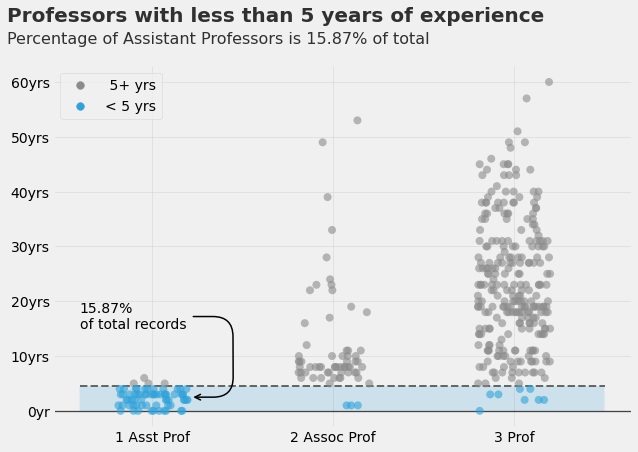

In [ ]:
# Plot
yrs_service_5_color_palette = {
    '< 5 yrs': '#30a2da',
    ' 5+ yrs': '#8b8b8b'
}
g = sns.catplot(data=salaries, x='rank', y='yrs_service', hue='yrs_service_5', order=rank_factors, palette=yrs_service_5_color_palette, alpha=.6, legend=False, jitter='0.2', s=8)
g.fig.set_figwidth(9)
g.fig.set_figheight(6.5)
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(year_formatter)
    ax.grid(axis='both', alpha=.4)
    ax.set_ylabel('')
    ax.set_xlabel('')
    handles, labels = custom_sort_legend(ax.get_legend_handles_labels())
    ax.legend(handles, labels, loc=0)
# Region < 5yrs
plt.hlines(4.5, -.4, 2.5, color='#666666', linestyles="--", lw=2)
plt.fill_between(np.arange(-.4, 2.5, .001), 0, 4.5, alpha=.15)
plt.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)
# Annotation
plt.annotate("15.87%\nof total records",
             xy=(0.2, 2.5), xycoords='data',
             xytext=(-.4, 15), textcoords='data',
             arrowprops=dict(arrowstyle="->", color="black", lw=1.5,
                            shrinkA=5, shrinkB=5,
                            connectionstyle="arc,angleA=0,angleB=0,armA=100,armB=45,rad=20",
                            ),
            )
# Adding a title and a subtitle
plt.text(x=-.8, y=71, s='Professors with less than 5 years of experience', fontsize=20, weight='bold', alpha=.8)
plt.text(x=-.8, y=67, s='Percentage of Assistant Professors is 15.87% of total', fontsize=16, alpha=.8)
plt.tight_layout(pad=1)

### **(2) Is there a statistically significant difference between female and male salaries?**

---



The histograms shows salaries by sex are not normally distributed.

The boxplots shows that Male has higher salaries (\~50% with more than \$100k) than Female (~50\% with less than \$100k) professors. 

So, it appears has a difference between female and male salaries.

In [ ]:
# Salary by sex
salary_female = salaries.query('sex == "Female"')['salary'].values
salary_male = salaries.query('sex == "Male"')['salary'].values

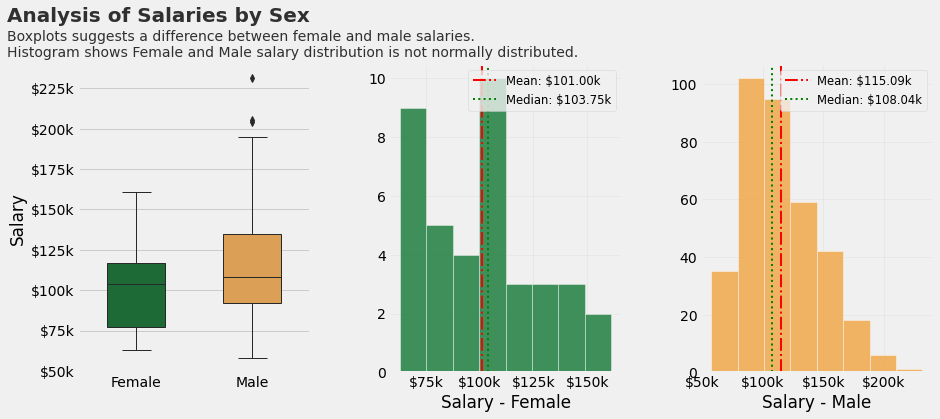

In [ ]:
# Setting size
fig, ax = plt.subplots(figsize=(14, 6))
fig_layout = (1, 3)
# Boxplot salary by sex
ax1 = custom_boxplot(data=salaries, x='sex', y='salary',  xlabel='', ylabel='Salary', factor_order=sex_factors, color_palette=sex_color_palette, layout=fig_layout, loc=(0, 0), f_formatter=dollar_formatter)
# Histogram Female Salary
ax2 = custom_histogram(data=salaries.query('sex == "Female"'), x='salary', xlabel='Salary - Female', layout=fig_layout, loc=(0, 1), f_formatter=dollar_formatter, color_hist='#117733')
# Histogram Male Salary
ax3 = custom_histogram(data=salaries.query('sex =="Male"'), x='salary', xlabel='Salary - Male', layout=fig_layout, loc=(0, 2), f_formatter=dollar_formatter, color_hist='#F1A340')
# Title
plt.gcf().text(0.04, 1, 'Analysis of Salaries by Sex', fontsize=20, weight='bold', alpha=.8)
plt.gcf().text(0.04, .92, 'Boxplots suggests a difference between female and male salaries.\nHistogram shows Female and Male salary distribution is not normally distributed.', fontsize=14, alpha=.8)
plt.tight_layout(pad=3)

In [ ]:
# Test for normality using using Jarque-Bera test
print('Female: %s' % custom_normality_test(salary_female))
print('Male: %s' % custom_normality_test(salary_male))

Female: {'jb_stat': 2.012838, 'jb_pvalue': 0.365526, 'skew': 0.440224, 'kurtosis': 2.319206}
Male: {'jb_stat': 31.191087, 'jb_pvalue': 0.0, 'skew': 0.717868, 'kurtosis': 3.17229}


The male salary is not normally distributed (Jarque-Bera test: p-value << 0.001). The female salary is normally distributed based on test (Jarque-Bera test: p-value=.36) but its histogram does not appear normally distributed.
 
Based on this results, we will use Mann-Whitney U test, a nonparametric test, to verify if there is a statistically significant difference between female and male salaries.
<br></br>

In [ ]:
# Mann-Whitney U test results
print(dict(zip(['stat', 'pvalue'], mannwhitneyu(salary_female, salary_male))))

{'stat': 5182.5, 'pvalue': 0.00411843164377889}


There is significant difference between female and male salaries (Mann-Whitney U test: p-value=0.004).



---



### **(3) What is the distribution of salary by rank and discipline?**

#### Boxplots of Salary by Rank and Discipline
---

The boxplots shows, in average, Professors has higher salaries (\~50\% with more than \$125k), followed by Associate Professors (\~50\% with less than \$95k) and Assistant Professor (\~50\% with less than \$80k) as expected. 

For Discipline, It suggests that Applied departments has higher salaries (\~75\% with more than \$100k) than Theoretical departments (\~50$ with less than \$100k).

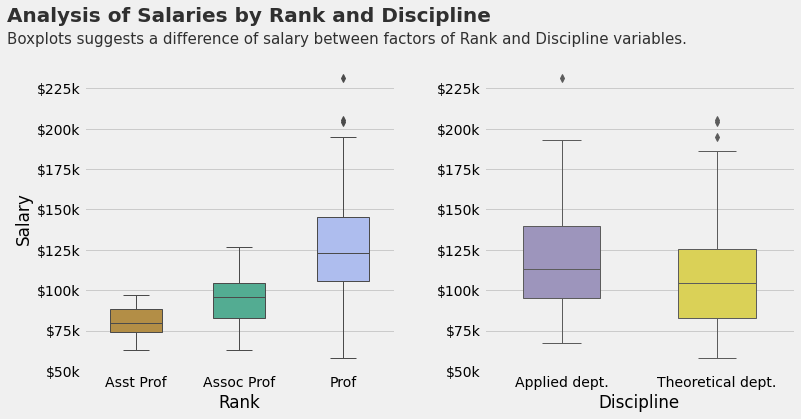

In [ ]:
# Setting size
fig, ax = plt.subplots(figsize=(12, 6))
fig_layout = (1, 2)
# Boxplot salary by discipline, rank
ax1 = custom_boxplot(data=salaries, x='rank', y='salary',  xlabel='Rank', ylabel='Salary', factor_order=rank_factors, color_palette=rank_color_palette, layout=fig_layout, loc=(0, 0), f_formatter=dollar_formatter)
ax2 = custom_boxplot(data=salaries, x='discipline', y='salary',  xlabel='Discipline', ylabel='', factor_order=discipline_factors, color_palette=discipline_color_palette, layout=fig_layout, loc=(0, 1), f_formatter=dollar_formatter)
# Title
plt.gcf().text(0.04, 1, 'Analysis of Salaries by Rank and Discipline', fontsize=20, weight='bold', alpha=.8)
plt.gcf().text(0.04, .95, 'Boxplots suggests a difference of salary between factors of Rank and Discipline variables.', fontsize=15, alpha=.8)
plt.tight_layout(pad=3)


#### Plot of Salary by Rank and Discipline
---

The plot shows Applied departments has higher salaries than Theoretical departments for Assistant and Associate Professors. For Full Professors, It does not suggests a clear difference between salaries of Applied and Theoretical departments.

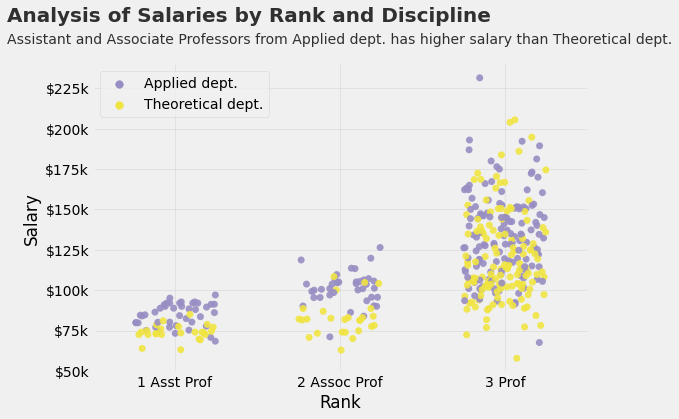

In [ ]:
# Scatterplot salary by rank, discipline
g = sns.catplot(data=salaries, x='rank', y='salary', hue='discipline', order=rank_factors, palette=discipline_color_palette, alpha=.9, legend=False, jitter='0.25', s=7)
g.fig.set_figwidth(9)
g.fig.set_figheight(6)
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(dollar_formatter)
    ax.set_ylabel('Salary')
    ax.set_xlabel('Rank')
    handles, labels = custom_sort_legend(ax.get_legend_handles_labels())
    ax.legend(handles, labels)
    ax.grid(axis='both', alpha=.4)
# Title
plt.gcf().text(0.04, 1, 'Analysis of Salaries by Rank and Discipline', fontsize=20, weight='bold', alpha=.8)
plt.gcf().text(0.04, .95, 'Assistant and Associate Professors from Applied dept. has higher salary than Theoretical dept.', fontsize=14, alpha=.8)
plt.tight_layout(pad=3)



---



### **(4) How would you recode discipline as a 0/1 binary indicator?**

In regression analysis, the most common encoding of categorical variables is dummy coding. Only g-1 (g being number of factors) are coded.

In [ ]:
# Discipline factors:
discipline_to_binary_map = {
    'Applied dept.': 0,
    'Theoretical dept.': 1,
}

# Discipline has 2 factors and it is a nominal type.
# So we can use .map() method to transform in binary indicator.
discipline_binary = salaries['discipline'].map(discipline_to_binary_map)
print('example of factor: %s' % (salaries.discipline.values[15:19]))
print('example of binary encode: %s' % (discipline_binary.values[15:19]))

# Some regression implementations has categorical operator that 
# it does the correct encoding for us.

example of factor: ['Applied dept.' 'Applied dept.' 'Theoretical dept.' 'Theoretical dept.']
example of binary encode: [0 0 1 1]




---



## **4.2 Model Building**

### **1st Approach for modeling Salary**

Build a predictive model using salary as the response. Use any model specification and related data transformations you deem to be most appropriate for this analysis. Prepare a clear and easily understandable interpretation of the results.

In [ ]:
# Split dataset into train and test
train, test = train_test_split(salaries, test_size=0.2, random_state=22)

#### Candidates models

For first model, we will use Multiple linear Regression Model.


${\displaystyle \mathbf {y} =X{\boldsymbol {\beta }}+{\boldsymbol {\varepsilon }},\,}$

where

$\mathbf {y} ={\begin{pmatrix}y_{1}\\y_{2}\\\vdots \\y_{n}\end{pmatrix}},\quad
{\displaystyle X={\begin{pmatrix}\mathbf {x} _{1}^{\mathsf {T}}\\\mathbf {x} _{2}^{\mathsf {T}}\\\vdots \\\mathbf {x} _{n}^{\mathsf {T}}\end{pmatrix}}={\begin{pmatrix}1&x_{11}&\cdots &x_{1p}\\1&x_{21}&\cdots &x_{2p}\\\vdots &\vdots &\ddots &\vdots \\1&x_{n1}&\cdots &x_{np}\end{pmatrix}},\quad}
{\displaystyle {\boldsymbol {\beta }}={\begin{pmatrix}\beta _{0}\\\beta _{1}\\\beta _{2}\\\vdots \\\beta _{p}\end{pmatrix}},\quad {\boldsymbol {\varepsilon }}={\begin{pmatrix}\varepsilon _{1}\\\varepsilon _{2}\\\vdots \\\varepsilon _{n}\end{pmatrix}}.}$


- $\mathbf {y}$: vector of observed values.
- $X$: matrix of explanatory variables.
- $\boldsymbol \beta$: parameter vector;
- $\boldsymbol \varepsilon$: vector of errors (residuals).
<br></br>


Salary could not have level zero, i.e., we can model without intercept.

For modeling Salary as response, we will start with a model with all variables and remove the variables that are not significant. To avoid multicollinearity, if both Years since PhD and Years of Service are significant, we will keep only Years since PhD due high correlation between them.

Other candidates models will be with one explanatory variable to analyse if only one is enough to explain Salary level. See table below.
<br></br>
 
| Model   | Explanatory Variables |
|---------|---|
| $ \text{Model All} $  | $ \text{Rank, Discipline, Sex, Years since PhD, Years of Service} $ |
| $ \text{Model 1} $  | $ \text{Rank, Discipline, Years since PhD} $ |
| $ \text{Model 2} $  | $ \text{Rank, Discipline} $ |
| $ \text{Model 3} $  | $ \text{Rank} $ |
| $ \text{Model 4} $  | $ \text{Discipline} $ |
| $ \text{Model 5} $  | $ \text{Sex} $ |
| $ \text{Model 6} $  | $ \text{Years since PhD} $ |


Results shows:

- Sex is not significant in Model with all variables.
- Years since PhD is not significant in Model 1.
- Other models has significant variables.

Comparing results of models with all variables significance:

- The Model 2 has lower AIC (7262) and variables explain 44% of the variability in Salary.
- The Model 6 has higher AIC (7804) and variables explain 79% of the variability in Salary.
- The Models 4 and 5 are significant at 5% but borderline for F Test `(null hypothesis: all coefficients are zero)`. 
- The Models 2, 3, and 6 are significant for F Test.
- The Models 3, 4 and 5 has Adjusted R-squared lower than .4.

Based on this results, we will analyse the residuals of candidates Models 2 and 6.
<br></br>

#### Results of candidates models

Results for Model with all variables shows:
- Sex is not significant `(p-value = 0.3, CI95% [-4375.9, 12579.2])`
- Years of Service and Years since PhD are very strongly correlated (.91) as expected. So, we only keep Years since PhD to avoid multicollinearity.
- Other variables are significant `(p-value < .05)`.

In [ ]:
model_all = smf.ols('salary ~ C(rank) + C(discipline) + C(sex) + yrs_since_phd + yrs_service -1', data=train).fit()
print('Model All Variables\n------', model_all.summary2())

Model All Variables
------                                 Results: Ordinary least squares
Model:                        OLS                       Adj. R-squared:              0.452     
Dependent Variable:           salary                    AIC:                         7257.9103 
Date:                         2020-04-15 22:33          BIC:                         7284.2226 
No. Observations:             317                       Log-Likelihood:              -3622.0   
Df Model:                     6                         F-statistic:                 44.37     
Df Residuals:                 310                       Prob (F-statistic):          4.91e-39  
R-squared:                    0.462                     Scale:                       5.0290e+08
-----------------------------------------------------------------------------------------------
                                      Coef.     Std.Err.    t    P>|t|     [0.025      0.975]  
---------------------------------------------

Results for Model with Rank, Discipline and Years since PhD variables shows:
- Years since PhD is not significant `(p-value = 0.3, CI95% [-143.7, 410.2])`
- Other variables are significant `(p-value < .05)`.

In [ ]:
model_1 = smf.ols('salary ~ C(rank) + C(discipline) + yrs_since_phd -1', data=train).fit()
print('Model 1\n------', model_1.summary2())

Model 1
------                                 Results: Ordinary least squares
Model:                        OLS                       Adj. R-squared:              0.438     
Dependent Variable:           salary                    AIC:                         7263.5789 
Date:                         2020-04-15 22:33          BIC:                         7282.3734 
No. Observations:             317                       Log-Likelihood:              -3626.8   
Df Model:                     4                         F-statistic:                 62.64     
Df Residuals:                 312                       Prob (F-statistic):          8.17e-39  
R-squared:                    0.445                     Scale:                       5.1515e+08
-----------------------------------------------------------------------------------------------
                                      Coef.     Std.Err.    t    P>|t|     [0.025      0.975]  
---------------------------------------------------------

Results for Model with Rank and Discipline variables shows:
- Rank and Discipline are significant `(p-value < .05)`.

In [ ]:
model_2 = smf.ols('salary ~ C(rank) + C(discipline) -1', data=train).fit()
print('Model 2\n------', model_2.summary2())

Model 2
------                                 Results: Ordinary least squares
Model:                        OLS                       Adj. R-squared:              0.438     
Dependent Variable:           salary                    AIC:                         7262.4879 
Date:                         2020-04-15 22:33          BIC:                         7277.5235 
No. Observations:             317                       Log-Likelihood:              -3627.2   
Df Model:                     3                         F-statistic:                 83.24     
Df Residuals:                 313                       Prob (F-statistic):          1.28e-39  
R-squared:                    0.444                     Scale:                       5.1498e+08
-----------------------------------------------------------------------------------------------
                                      Coef.     Std.Err.    t    P>|t|     [0.025      0.975]  
---------------------------------------------------------

Results for Model with only Rank shows:
- Rank is significant `(p-value < .05)`.

In [ ]:
model_3 = smf.ols('salary ~ C(rank) -1', data=train).fit()
print('Model 3\n------', model_3.summary2())

Model 3
------                          Results: Ordinary least squares
Model:                   OLS                   Adj. R-squared:          0.393     
Dependent Variable:      salary                AIC:                     7286.1071 
Date:                    2020-04-15 22:34      BIC:                     7297.3838 
No. Observations:        317                   Log-Likelihood:          -3640.1   
Df Model:                2                     F-statistic:             103.3     
Df Residuals:            314                   Prob (F-statistic):      3.27e-35  
R-squared:               0.397                 Scale:                   5.5655e+08
----------------------------------------------------------------------------------
                         Coef.     Std.Err.    t    P>|t|     [0.025      0.975]  
----------------------------------------------------------------------------------
C(rank)[1 Asst Prof]   81614.3208 3240.5187 25.1856 0.0000  75238.4457  87990.1958
C(rank)[2 Assoc

Results for Model with only Discipline shows:
- Discipline is significant `(p-value < .05)`.

In [ ]:
model_4 = smf.ols('salary ~ C(discipline) -1', data=train).fit()
print('Model 4\n------', model_4.summary2())

Model 4
------                                Results: Ordinary least squares
Model:                        OLS                      Adj. R-squared:             0.011     
Dependent Variable:           salary                   AIC:                        7439.8829 
Date:                         2020-04-15 22:34         BIC:                        7447.4007 
No. Observations:             317                      Log-Likelihood:             -3717.9   
Df Model:                     1                        F-statistic:                4.559     
Df Residuals:                 315                      Prob (F-statistic):         0.0335    
R-squared:                    0.014                    Scale:                      9.0686e+08
---------------------------------------------------------------------------------------------
                                    Coef.     Std.Err.    t    P>|t|     [0.025      0.975]  
----------------------------------------------------------------------------

Results for Model with only Sex shows:
- Sex is significant `(p-value < .05)`.

In [ ]:
model_5 = smf.ols('salary ~ C(sex) -1', data=train).fit()
print('Model 5\n------', model_5.summary2())

Model 5
------                       Results: Ordinary least squares
Model:                  OLS                Adj. R-squared:       0.010     
Dependent Variable:     salary             AIC:                  7440.3387 
Date:                   2020-04-15 22:34   BIC:                  7447.8565 
No. Observations:       317                Log-Likelihood:       -3718.2   
Df Model:               1                  F-statistic:          4.099     
Df Residuals:           315                Prob (F-statistic):   0.0437    
R-squared:              0.013              Scale:                9.0816e+08
---------------------------------------------------------------------------
                  Coef.     Std.Err.    t    P>|t|     [0.025      0.975]  
---------------------------------------------------------------------------
C(sex)[Female] 103756.5806 5412.5373 19.1697 0.0000  93107.2862 114405.8751
C(sex)[Male]   115294.0874 1781.9632 64.7006 0.0000 111788.0329 118800.1419
-------------------

Results for Model with only Years since PhD shows:
- Years since PhD is significant `(p-value < .05)`.

In [ ]:
model_6 = smf.ols('salary ~ yrs_since_phd -1', data=train).fit()
print('Model 6\n------', model_6.summary2())

Model 6
------                         Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.794     
Dependent Variable:     salary           AIC:                         7804.7144 
Date:                   2020-04-15 22:34 BIC:                         7808.4733 
No. Observations:       317              Log-Likelihood:              -3901.4   
Df Model:               1                F-statistic:                 1222.     
Df Residuals:           316              Prob (F-statistic):          1.35e-110 
R-squared (uncentered): 0.794            Scale:                       2.8756e+09
----------------------------------------------------------------------------------
                     Coef.     Std.Err.      t      P>|t|      [0.025      0.975] 
----------------------------------------------------------------------------------
yrs_since_phd      4092.1434   117.0808   34.9515   0.0000   3861.7871   4322.4998
------------------------------

Comparing results of models with all variables significance:

In [ ]:
# Models with all explanatory variables significants:
models = zip(['Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6'], [model_2, model_3, model_4, model_5, model_6])

# Stats Summary
print("=" * 84)
print('%s     %-9s %s   %s   %s' % ('Model', 'AIC', 'F p-value', 'Adj. R-squared', 'Formula'))
print("-" * 84)
for i, m in models:
    print('%s   %.2f   %.5f     %.2f             %s' % (i, m.aic, m.f_pvalue, m.rsquared_adj, m.model.formula))
print("=" * 84)

Model     AIC       F p-value   Adj. R-squared   Formula
------------------------------------------------------------------------------------
Model 2   7262.49   0.00000     0.44             salary ~ C(rank) + C(discipline) -1
Model 3   7286.11   0.00000     0.39             salary ~ C(rank) -1
Model 4   7439.88   0.03352     0.01             salary ~ C(discipline) -1
Model 5   7440.34   0.04374     0.01             salary ~ C(sex) -1
Model 6   7804.71   0.00000     0.79             salary ~ yrs_since_phd -1


#### Residual Analysis of Candidates Models 2 and 6

The Residuals tests shows both models does not have normal distributed residuals, and Homoscedasticity as well.
 
Visualizing residuals bellow.

In [ ]:
# Residuals test
custom_resid_tests(model_2, title='Model 2')

Model 2
Formula: salary ~ C(rank) + C(discipline) -1

Residual Tests
---
Normality: Jarque-Bera test
{'jb_stat': 104.26313, 'jb_pvalue': 0.0, 'skew': 0.92868, 'kurtosis': 5.10807}
---
Independence: Ljung-Box test
{'lb_stat': 0.2503953532003696, 'lb_pvalue': 0.6167968346145636}
---
Homoscedasticity: Breusch-Pagan test
{'LM_stat': 27.86155, 'LM_pvalue': 0.0, 'F_stat': 10.05362, 'F_pvalue': 0.0}


In [ ]:
custom_resid_tests(model_6, title='Model 6')

Model 6
Formula: salary ~ yrs_since_phd -1

Residual Tests
---
Normality: Jarque-Bera test
{'jb_stat': 69.97742, 'jb_pvalue': 0.0, 'skew': -1.05681, 'kurtosis': 3.91136}
---
Independence: Ljung-Box test
{'lb_stat': 1.665790637368515, 'lb_pvalue': 0.19682329378457103}
---
Homoscedasticity: Breusch-Pagan test
{'LM_stat': 110.09037, 'LM_pvalue': nan, 'F_stat': 168.13407, 'F_pvalue': 0.0}


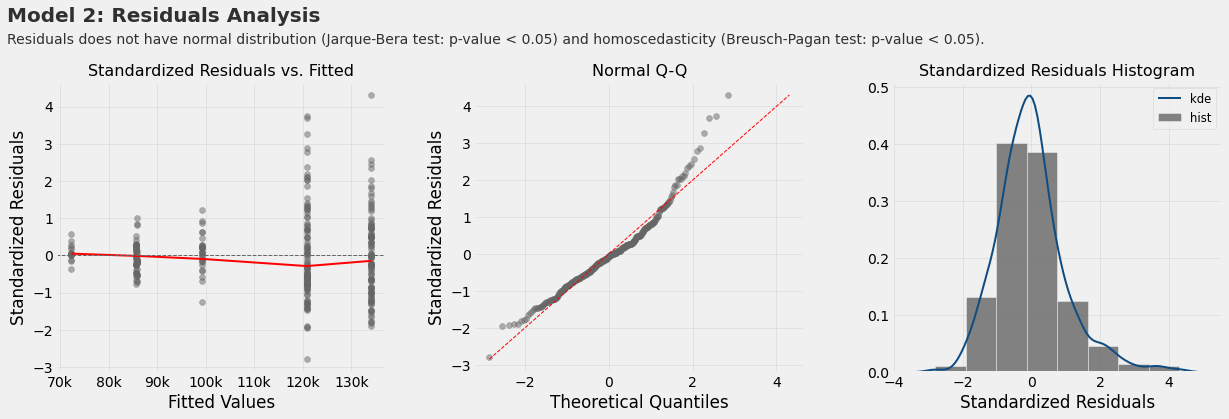

In [ ]:
# Residuals plot for Model 2
custom_residual_plots(model_2, figsize=(18, 6))
# Title
plt.gcf().text(0.03, 1, 'Model 2: Residuals Analysis', fontsize=20, weight='bold', alpha=.8)
plt.gcf().text(0.03, .95, 'Residuals does not have normal distribution (Jarque-Bera test: p-value < 0.05) and homoscedasticity (Breusch-Pagan test: p-value < 0.05).', fontsize=14, alpha=.8)
plt.tight_layout(pad=3)

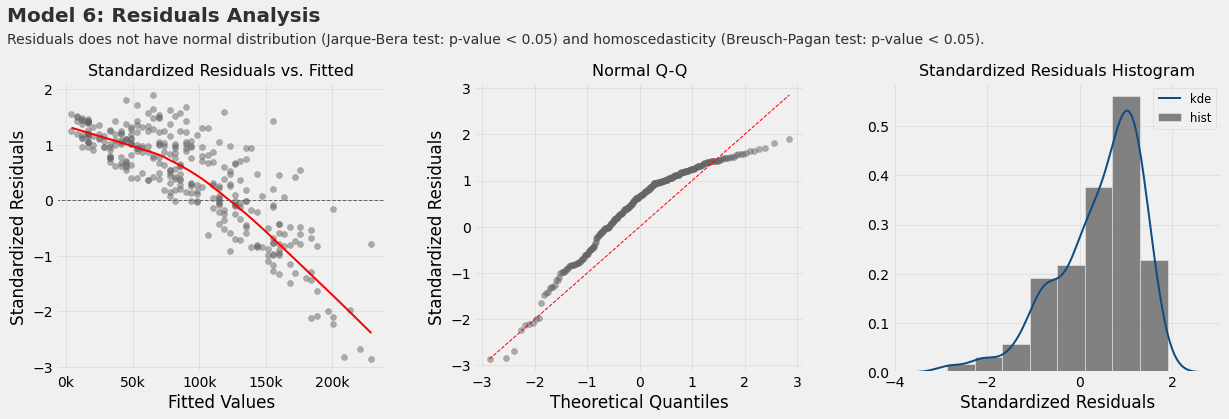

In [ ]:
# Residuals plot for Model 6
custom_residual_plots(model_6, figsize=(18, 6))
# Title
plt.gcf().text(0.03, 1, 'Model 6: Residuals Analysis', fontsize=20, weight='bold', alpha=.8)
plt.gcf().text(0.03, .95, 'Residuals does not have normal distribution (Jarque-Bera test: p-value < 0.05) and homoscedasticity (Breusch-Pagan test: p-value < 0.05).', fontsize=14, alpha=.8)
plt.tight_layout(pad=3)


For both models 2 and 6, the plots suggests that residuals are not normally distributed residuals, it has Heteroscedasticity as well.
 
The linear regression assumes that the variability of the residuals is constant. In both models, it shows pattern that it is not constant. Violating this assumption may lead to conclude the model terms is statistically significant when it is actually not significant.
 
To fix heteroskedasticity, we can use new predictors or using Box-Cox transformation.

In this first model analysis, we will use Box-Cox Transformation.
<br></br>

In [ ]:
# Transformation
endog_in_transformed, maxlog, interval = boxcox(salaries.salary, alpha=0.05)
print('Lambda: %.2f \nCI 95%%: [ %.2f, %.2f ]' % (maxlog, interval[0], interval[1]))

Lambda: -0.24 
CI 95%: [ -0.59, 0.12 ]


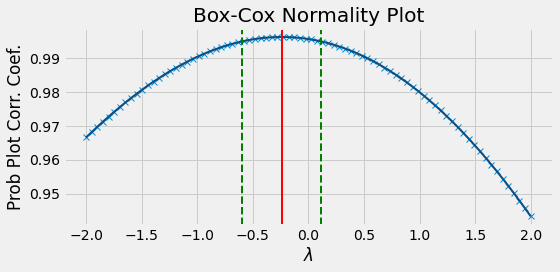

In [ ]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
prob = boxcox_normplot(salaries.salary, -2, 2, plot=ax)
plt.plot(prob[0], prob[1], color='#0f4c81', lw=2)
ax.axvline(maxlog, color='r', lw=2)
ax.axvline(interval[1], color='g', ls='--', lw=2)
ax.axvline(interval[0], color='g',ls='--', lw=2)
plt.tight_layout()

The Box-Cox Transformation suggests two:
- Inverse Square Root
- Logarithm.
<br></br>

In [ ]:
# Transformations
def f_log(x):
    return np.log(x)

def f_invsqrt(x):
    return np.power(x, -.5)

In [ ]:
# Model 2 with transformations
model_2_log = smf.ols('np.log(salary) ~ C(rank) + C(discipline) -1', data=train).fit()
print('Model 2 - Log Salary\n------', model_2_log.summary2())

model_2_invsqrt = smf.ols('f_invsqrt(salary) ~ C(rank) + C(discipline) -1', data=train).fit()
print('Model 2 - InvSqrt Salary\n------', model_2_invsqrt.summary2())

Model 2 - Log Salary
------                           Results: Ordinary least squares
Model:                     OLS                   Adj. R-squared:          0.515    
Dependent Variable:        np.log(salary)        AIC:                     -184.8766
Date:                      2020-04-15 22:39      BIC:                     -169.8410
No. Observations:          317                   Log-Likelihood:          96.438   
Df Model:                  3                     F-statistic:             112.7    
Df Residuals:              313                   Prob (F-statistic):      1.70e-49 
R-squared:                 0.519                 Scale:                   0.032270 
-----------------------------------------------------------------------------------
                                    Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-----------------------------------------------------------------------------------
C(rank)[1 Asst Prof]               11.3428   0.0254 445.8857 0.0000 11.292

In [ ]:
# Model 6 with transformations
model_6_log = smf.ols('np.log(salary) ~ yrs_since_phd -1', data=train).fit()
print('Model 6 - Log Salary\n------', model_6_log.summary2())

model_6_invsqrt = smf.ols('f_invsqrt(salary) ~ yrs_since_phd -1', data=train).fit()
print('Model 6 - InvSqrt Salary\n------', model_6_invsqrt.summary2())

Model 6 - Log Salary
------                         Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.757    
Dependent Variable:     np.log(salary)   AIC:                         2006.7496
Date:                   2020-04-15 22:39 BIC:                         2010.5085
No. Observations:       317              Log-Likelihood:              -1002.4  
Df Model:               1                F-statistic:                 989.1    
Df Residuals:           316              Prob (F-statistic):          2.46e-99 
R-squared (uncentered): 0.758            Scale:                       32.767   
-----------------------------------------------------------------------------------
                   Coef.      Std.Err.        t        P>|t|      [0.025     0.975]
-----------------------------------------------------------------------------------
yrs_since_phd      0.3931       0.0125     31.4500     0.0000     0.3685     0.4176
--------------------

Coefficients for models with transformation are significant `(p-value < .5)`.

In [ ]:
# Models with transformations:
models = zip(
    ['Model 2', 'Model 2 - Log Salary', 'Model 2 - InvSqrt Salary', 'Model 6', 'Model 6 - Log Salary', 'Model 6 - InvSqrt Salary'],
    [model_2, model_2_log, model_2_invsqrt, model_6, model_6_log, model_6_invsqrt]
)

# Stats Summary
print("=" * 103)
print('%-25s   %s   %s   %s' % ('Model', 'F p-value', 'Adj. R-squared', 'Formula'))
print("-" * 103)
for i, m in models:
    s = [i, m.f_pvalue, m.rsquared_adj] + m.model.formula.split('~')
    print('%-25s   %.5f     %.2f             %18s~%s' % tuple(s))
print("=" * 103)

Model                       F p-value   Adj. R-squared   Formula
-------------------------------------------------------------------------------------------------------
Model 2                     0.00000     0.44                        salary ~ C(rank) + C(discipline) -1
Model 2 - Log Salary        0.00000     0.51                np.log(salary) ~ C(rank) + C(discipline) -1
Model 2 - InvSqrt Salary    0.00000     0.54             f_invsqrt(salary) ~ C(rank) + C(discipline) -1
Model 6                     0.00000     0.79                        salary ~ yrs_since_phd -1
Model 6 - Log Salary        0.00000     0.76                np.log(salary) ~ yrs_since_phd -1
Model 6 - InvSqrt Salary    0.00000     0.69             f_invsqrt(salary) ~ yrs_since_phd -1


The Residuals tests shows models with transformation does not have normal distributed residuals, and Homoscedasticity as well.

Visualizing residuals bellow.

In [ ]:
# Residuals tests
custom_resid_tests(model_2_log, 'Model 2 - Log Salary')

Model 2 - Log Salary
Formula: np.log(salary) ~ C(rank) + C(discipline) -1

Residual Tests
---
Normality: Jarque-Bera test
{'jb_stat': 15.90474, 'jb_pvalue': 0.00035, 'skew': 0.22492, 'kurtosis': 4.00089}
---
Independence: Ljung-Box test
{'lb_stat': 0.42871564806418777, 'lb_pvalue': 0.5126198339905608}
---
Homoscedasticity: Breusch-Pagan test
{'LM_stat': 27.61786, 'LM_pvalue': 0.0, 'F_stat': 9.9573, 'F_pvalue': 0.0}


In [ ]:
custom_resid_tests(model_2_invsqrt, 'Model 2 - InvSqrt Salary')

Model 2 - InvSqrt Salary
Formula: f_invsqrt(salary) ~ C(rank) + C(discipline) -1

Residual Tests
---
Normality: Jarque-Bera test
{'jb_stat': 21.95857, 'jb_pvalue': 2e-05, 'skew': 0.13482, 'kurtosis': 4.26086}
---
Independence: Ljung-Box test
{'lb_stat': 0.44364362416401826, 'lb_pvalue': 0.5053690556489262}
---
Homoscedasticity: Breusch-Pagan test
{'LM_stat': 20.22753, 'LM_pvalue': 0.00015, 'F_stat': 7.11119, 'F_pvalue': 0.00012}


In [ ]:
custom_resid_tests(model_6_log, 'Model 6 - Log Salary')

Model 6 - Log Salary
Formula: np.log(salary) ~ yrs_since_phd -1

Residual Tests
---
Normality: Jarque-Bera test
{'jb_stat': 14.01521, 'jb_pvalue': 0.0009, 'skew': -0.40278, 'kurtosis': 2.358}
---
Independence: Ljung-Box test
{'lb_stat': 1.391814469956878, 'lb_pvalue': 0.2380989179812932}
---
Homoscedasticity: Breusch-Pagan test
{'LM_stat': 52.76232, 'LM_pvalue': nan, 'F_stat': 63.09809, 'F_pvalue': 0.0}


In [ ]:
custom_resid_tests(model_6_invsqrt, 'Model 6 - InvSqrt Salary')

Model 6 - InvSqrt Salary
Formula: f_invsqrt(salary) ~ yrs_since_phd -1

Residual Tests
---
Normality: Jarque-Bera test
{'jb_stat': 9.86318, 'jb_pvalue': 0.00722, 'skew': -0.02235, 'kurtosis': 2.13702}
---
Independence: Ljung-Box test
{'lb_stat': 0.4491762795640228, 'lb_pvalue': 0.5027263858150954}
---
Homoscedasticity: Breusch-Pagan test
{'LM_stat': 32.23503, 'LM_pvalue': nan, 'F_stat': 35.7708, 'F_pvalue': 0.0}


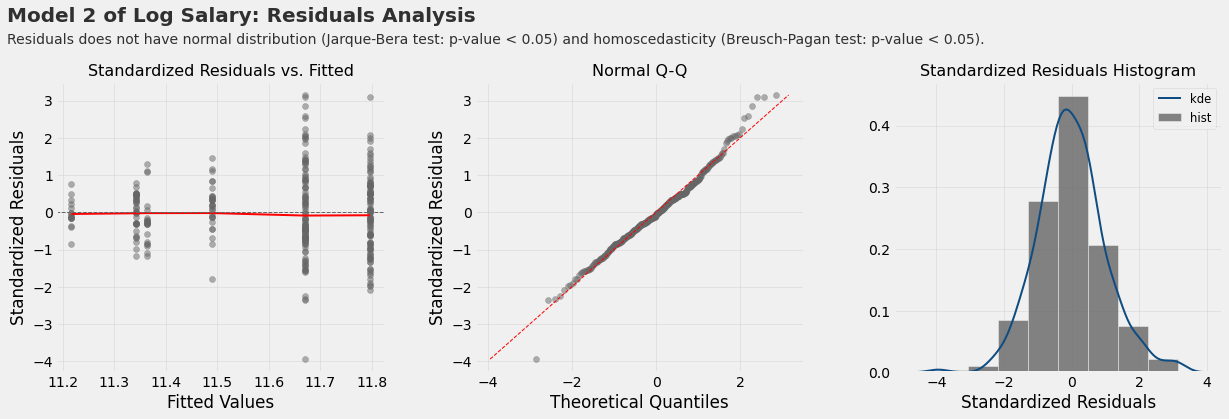

In [ ]:
custom_residual_plots(model_2_log, figsize=(18, 6), transf=True)
plt.gcf().text(0.03, 1, 'Model 2 of Log Salary: Residuals Analysis', fontsize=20, weight='bold', alpha=.8)
plt.gcf().text(0.03, .95, 'Residuals does not have normal distribution (Jarque-Bera test: p-value < 0.05) and homoscedasticity (Breusch-Pagan test: p-value < 0.05).', fontsize=14, alpha=.8)
plt.tight_layout(pad=3)

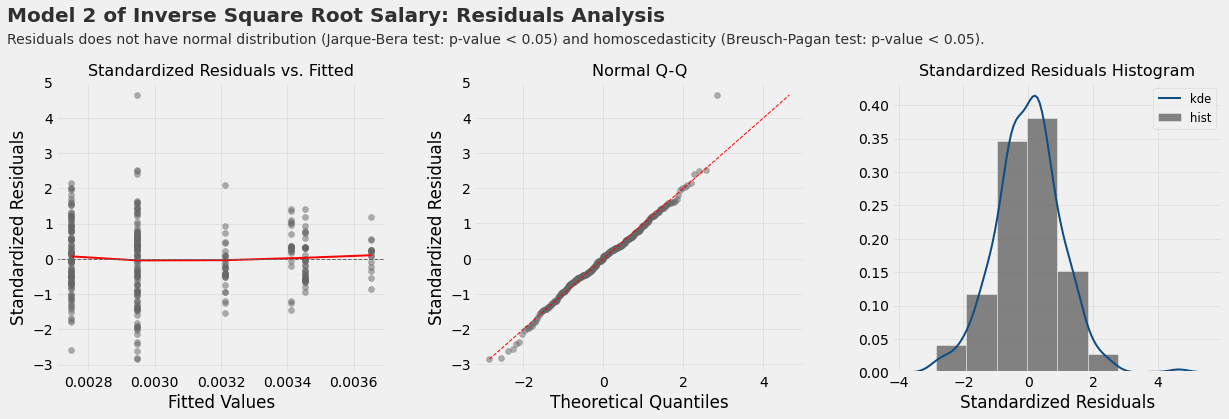

In [ ]:
custom_residual_plots(model_2_invsqrt, figsize=(18, 6), transf=True)
plt.gcf().text(0.03, 1, 'Model 2 of Inverse Square Root Salary: Residuals Analysis', fontsize=20, weight='bold', alpha=.8)
plt.gcf().text(0.03, .95, 'Residuals does not have normal distribution (Jarque-Bera test: p-value < 0.05) and homoscedasticity (Breusch-Pagan test: p-value < 0.05).', fontsize=14, alpha=.8)
plt.tight_layout(pad=3)

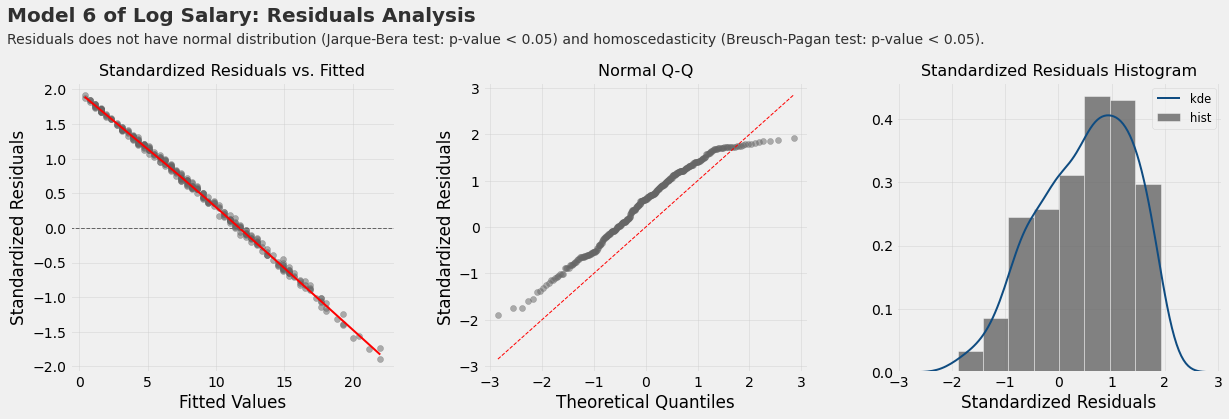

In [ ]:
custom_residual_plots(model_6_log, figsize=(18, 6), transf=True)
plt.gcf().text(0.03, 1, 'Model 6 of Log Salary: Residuals Analysis', fontsize=20, weight='bold', alpha=.8)
plt.gcf().text(0.03, .95, 'Residuals does not have normal distribution (Jarque-Bera test: p-value < 0.05) and homoscedasticity (Breusch-Pagan test: p-value < 0.05).', fontsize=14, alpha=.8)
plt.tight_layout(pad=3)

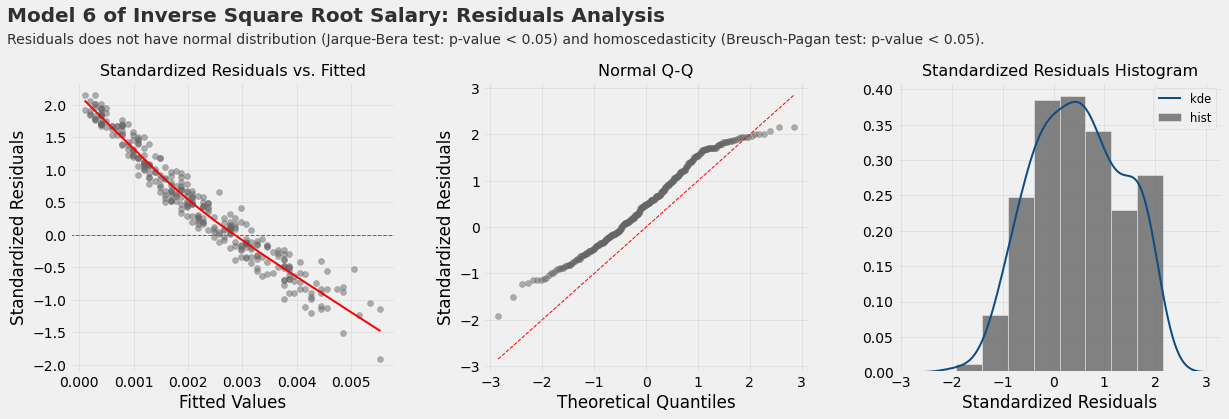

In [ ]:
custom_residual_plots(model_6_invsqrt, figsize=(18, 6), transf=True)
plt.gcf().text(0.03, 1, 'Model 6 of Inverse Square Root Salary: Residuals Analysis', fontsize=20, weight='bold', alpha=.8)
plt.gcf().text(0.03, .95, 'Residuals does not have normal distribution (Jarque-Bera test: p-value < 0.05) and homoscedasticity (Breusch-Pagan test: p-value < 0.05).', fontsize=14, alpha=.8)
plt.tight_layout(pad=3)

#### Best model: Model 2 without transformation

For both models 2 and 6 with transformations, the plots suggests that residuals are not normally distributed residuals, it has Heteroscedasticity as well.

The Scatterplot of Salary and Years since PhD indicates when increases years, it increases salary, but for some professores this is not true.

The plots of Salary and Rank and Discipline shows for Assistant and Associate by Discipline salary could be higher or low.

Keep in mind this two plots and that these models could results inefficient and unstable, we will use model 2 to predict in our test data.

We will use Cross-Validation for RMSE and MEA statistics in train set to comparing with test set statistics.
<br></br>

In [ ]:
# Train K-fold cross-validation - RMSE and MAE
scores_rmse = cross_val_score(LinearRegression(), model_2.model.exog, model_2.model.endog, scoring='neg_root_mean_squared_error', cv=10)
scores_mae = cross_val_score(LinearRegression(), model_2.model.exog, model_2.model.endog, scoring='neg_mean_absolute_error', cv=10)

In [ ]:
# Prediction, RMSE and MAE
pred = model_2.get_prediction(exog=test)
rmse_stat = np.sqrt(mean_squared_error(test.salary, pred.predicted_mean))
mae_stat = mean_absolute_error(test.salary, pred.predicted_mean)

In [ ]:
print('RMSE\n---')
print("Train: {:,.2f} (+/- {:,.2f})".format(-1*scores_rmse.mean(), scores_rmse.std() * 2))
print('Test: {:,.2f}'.format(rmse_stat))

print('\nMAE\n---')
print("Train: {:,.2f} (+/- {:,.2f})".format(-1*scores_mae.mean(), scores_mae.std() * 2))
print('Test: {:,.2f}'.format(mae_stat))

RMSE
---
Train: 22,609.45 (+/- 5,135.72)
Test: 22,540.10

MAE
---
Train: 16,756.42 (+/- 3,692.06)
Test: 16,935.76


Comparing statistics, it is not clear if model is underfitting, overfitting or good fit (RMSE and MAE stats in test set is lower than RMSE and MAE stats in train set).

This behavior is expected because Model violated 2 assumptions, Normality and Heteroscedasticity of residuals.

Next step is looking for a model more stable to estimate the mean of salary.
<br></br>

### **2nd Approach for modeling Salary**

In addition, create a 0/1 binary indicator using salary, where the indicator has a value of 0 if the salary is below the median and 1 otherwise. Build a new model using this indicator as the response, using the same set of predictors used to build the previous model.

In [ ]:
# Median of Salary
salary_median = salaries['salary'].median()
print('Median: $%.2fk' % (salary_median/1000))

Median: $107.30k


In [ ]:
# Create binary indicator
salaries['salary_binary'] = salaries['salary'].map(lambda x: '0' if x < salary_median else '1')

In [ ]:
print('%15s  %-6s  %-6s  %s' % ('Column', 'Dtype', 'NA', 'Values'))
print('%15s  %-6s  %-6s  %s' % ('------', '-----', '--', '------'))
for key, values in salaries.dtypes.items():
    print('%15s  %-6s  %d null  %s' % (key,
                                       values,
                                       salaries[key].isnull().sum(),
                                       salaries[key].values[:4])
    )

         Column  Dtype   NA      Values
         ------  -----   --      ------
           rank  object  0 null  ['3 Prof' '3 Prof' '1 Asst Prof' '3 Prof']
     discipline  object  0 null  ['Applied dept.' 'Applied dept.' 'Applied dept.' 'Applied dept.']
  yrs_since_phd  int64   0 null  [19 20  4 45]
    yrs_service  int64   0 null  [18 16  3 39]
            sex  object  0 null  ['Male' 'Male' 'Male' 'Male']
         salary  int64   0 null  [139750 173200  79750 115000]
  salary_binary  object  0 null  ['1' '1' '0' '1']


In [ ]:
# Table
pd.concat(
    [salaries['salary_binary'].value_counts(),
     salaries['salary_binary'].value_counts(normalize=True).mul(100).round(2)],
    axis=1, names='salary_binary', keys=('counts','percentage'), sort=True
)

salary_binary,counts,percentage
0,198,49.87
1,199,50.13


#### Candidate Model

For second model, we will use Logistic Regression:

$\text{logit}[P(Y=1)] = \ln\frac{P(Y=1)}{1-P(Y=1)} = \alpha + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_n X_n$

where

- $P(Y=1)$: is the probability that salary is higher than median.
- $X_1, X_2, \cdots, X_n$: are the explanatory variables.
- $\beta_1, \beta_2 X_2, \cdots, \beta_n$: are coefficients vector;
<br></br>


In [ ]:
# Split dataset into train and test
train, test = train_test_split(salaries, test_size=0.2, random_state=22)

# Model
model_binary = smf.glm('salary_binary ~ C(rank) + C(discipline)-1', data=train, family=sm.families.Binomial()).fit()
print('Model Binary Salary\n------', model_binary.summary2())

Model Binary Salary
------                              Results: Generalized linear model
Model:                GLM                                       AIC:             278.0216  
Link Function:        logit                                     BIC:             -1532.5147
Dependent Variable:   ['salary_binary[0]', 'salary_binary[1]']  Log-Likelihood:  -135.01   
Date:                 2020-04-16 17:48                          LL-Null:         -219.60   
No. Observations:     317                                       Deviance:        270.02    
Df Model:             3                                         Pearson chi2:    262.      
Df Residuals:         313                                       Scale:           1.0000    
Method:               IRLS                                                                 
-------------------------------------------------------------------------------------------
                                    Coef.   Std.Err.     z    P>|z|     [0.025    

In [ ]:
print('    Null deviance: %.2f on %d degrees of freedom' % (model_binary.null_deviance, model_binary.nobs))
print('Residual deviance: %.2f on %d degrees of freedom' % (model_binary.deviance, model_binary.df_resid))
print('              AIC: %.2f' % model_binary.aic)
print('        Pseudo-R2: %.2f' %(1 - (model_binary.deviance/model_binary.null_deviance)))

    Null deviance: 439.20 on 317 degrees of freedom
Residual deviance: 270.02 on 313 degrees of freedom
              AIC: 278.02
        Pseudo-R2: 0.39


In [ ]:
pd.Series(model_binary.resid_deviance).describe().to_dict()

{'25%': -0.5701718864672161,
 '50%': -0.5701718864672161,
 '75%': 0.6429922835606071,
 'count': 317.0,
 'max': 1.947796357078182,
 'mean': -0.060049501511279094,
 'min': -2.347938177419741,
 'std': 0.9224322319718173}

In [ ]:
# Classification metrics
threshold = .5

y_fitted = (model_binary.fittedvalues.values > threshold).astype(int)
y_train = model_binary.model.endog.astype(int)
print(classification_report(y_train, y_fitted))

y_pred = (model_binary.predict(exog=test).values > threshold).astype(int)
y_test = (test.salary_binary == '1').astype(int).values
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.96      0.83       163
           1       0.93      0.64      0.76       154

    accuracy                           0.80       317
   macro avg       0.83      0.80      0.79       317
weighted avg       0.83      0.80      0.80       317

              precision    recall  f1-score   support

           0       0.33      0.41      0.37        44
           1       0.00      0.00      0.00        36

    accuracy                           0.23        80
   macro avg       0.17      0.20      0.18        80
weighted avg       0.18      0.23      0.20        80



In [ ]:
# Logistic regression using sklearn package
# data
m = model_binary = smf.glm('salary_binary ~ C(rank) + C(discipline)-1', data=salaries, family=sm.families.Binomial()).fit()
X_train, X_test, y_train, y_test = train_test_split(m.model.exog, m.model.endog, test_size=0.2, random_state=22)
# classifier
logistic = LogisticRegression(random_state=0, fit_intercept=False)
# hyperparameter options
hyperparameters = dict(
    C=np.logspace(0, 4, 10), # regularization hyperparameter space
    penalty=['l1', 'l2'], # regularization penalty space
)
# grid search using 5-fold cross validation
clf = GridSearchCV(logistic, hyperparameters, cv=10, verbose=0)
# best model
best_model = clf.fit(X_train, y_train)

In [ ]:
# View best hyperparameters
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best Penalty: l2
Best C: 1.0


In [ ]:
y_pred = clf.predict(X_test)
print('Accuracy of logistic regression')
print('Train: {:.2f}'.format(clf.score(X_train, y_train)))
print('Test: {:.2f}'.format(clf.score(X_test, y_test)))
print(classification_report(y_test, y_pred))

Accuracy of logistic regression
Train: 0.80
Test: 0.78
              precision    recall  f1-score   support

         0.0       0.67      1.00      0.80        36
         1.0       1.00      0.59      0.74        44

    accuracy                           0.78        80
   macro avg       0.83      0.80      0.77        80
weighted avg       0.85      0.78      0.77        80



## **4.3 Data Set Enhancement**

Suppose you’ve been asked to enhance the existing data set to enable additional rounds of analysis and facilitate additional model development.

### **(1) State at least three research questions you would like to address and describe your thought process behind how you formulated these research questions.**

1. Is research productivity impact on salaries?

> In Mittal et. all (2008), they suggests that being full professor and from higher ranked research university are associated with higher salary.

2. Is race/ethnicity impact on salaries?

> In Guillory (2001), the author suggests that salaries does have significant impact by Race/ethnicity.

3. Will professors leave college?

> In Gofman and Jin (2019), they investigates the impact of AI human capital from research universities to the private sector could affected negatively in domain-specific transfer of knowledge to students.

<br></br>
**References:**

> Gofman, M., & Jin, Z. (2019). Artificial Intelligence, Human Capital, and Innovation. Human Capital, and Innovation (August 20, 2019).
>
> Guillory, E. A. (2001). The Black professoriate: Explaining the salary gap for African-American female professors. Race Ethnicity and Education, 4(3), 225-244.
>
> Mittal, V., Feick, L., & Murshed, F. (2008). Publish and prosper: The financial impact of publishing by marketing faculty. Marketing Science, 27(3), 430-442.

<br></br>

### **(2) Prepare a list of 5-7 additional attributes you would like to add to the data set. Prepare a brief explanation for each attribute.**

> *   **Research Productivity:** number of publications in different types of journals (Tier 1, Tier 2 and Tier 3).
> 
> *   **Race:** following [U.S. Census Bureau](https://www.census.gov/topics/population/race/about.html) with categories: (a) White, (b) Black or African American, (c) American Indian or Alaska Native, (d) Asian, (e) Native Hawaiian or Other Pacific Islander. 
> *   **Type of University:** private, four-year colleges and two-year colleges.
> 
> *   **Research Activity:** number of hours spent on research.
> 
> *   **Teaching Activity:** number of hours spent on teaching.
>
> *   **Field**: sciences, social sciences, technical, semi-technical, humanities, other.
> 
> *   **Turnover**: professor leave college to private sector.
<br></br>

### **(3) Estimate and justify the appropriate sample size (and sampling technique, if desired) that would be required to address the research questions you defined.**

> In 2017, National Center for Education Statistics [counted](https://nces.ed.gov/pubs2020/2020009.pdf) 182,388 Professors, 158,082 Associate professors, 173,409 Assistant professors (Total: 513,879).
> <br></br>
> 
> For first sampling, Yamane (1967) suggests, for a 95% confidence level and $p = 0.5$ (maximum variability), sample size is:

\begin{equation}
n = \frac{N}{1+N(e^{2})}
\end{equation}

> where $N$ is the population size, and $e$ is the desired level of precision.
> <br></br>
\begin{equation}
n = \frac{500000}{1+500000(.05^{2})} = 399.68
\end{equation}
> <br></br>
> 
> So, we will get sample size as $400$.

<br></br>
**References:**
> Snyder, T.D., de Brey, C., and Dillow, S.A. (2019). Digest of Education Statistics 2018 (NCES 2020-009). National Center for Education Statistics, Institute of Education Sciences, U.S. Department of Education.
Washington, DC.
>
> Yamane, Taro. 1967. Statistics, An Introductory Analysis, 2nd Ed., New York: Harper and Row.
>
<br></br>

# **5 Statistical Methods**

## Mann-Whitney U Test
---

The Mann-Whitney U test is a non-parametric test of two samples come from same population, i.e. have the same median.

Hypothesis:
 
\begin{align*}
H_{0} & : \text{the distributions of the two groups are equal.} \\
H_{a} & : \text{the medians of the two groups are not equal.}
\end{align*}



<br></br>

## Jarque-Bera Test
---

The Jarque–Bera test is a goodness-of-fit test of data have the skewness and kurtosis matching a Normal distribution. The test hypotheses are: 

\begin{align*}
H_{0} & : \text{the data is normally distributed.} \\
H_{a} & : \text{the data is not normally distributed.}
\end{align*}

The test statistic is based on the asymmetry and kurtosis coefficients of the data. Under the null hypothesis, it has an asymptotic $\chi _{(2)}^{2}$ distribution with 2 degrees of freedom, defined by:

\begin{equation}
JB = N \left ( \frac{S^2}{6}+ \frac{(K-3)^2}{24} \right )
\end{equation}

where $N$ is sample size; $S$ and $K$ are the asymmetry and kurtosis, respectively. The critical region for rejection of the null hypothesis is:

\begin{equation}
P \left ( \chi^2 \geq  JB | H_0 \right ) \leq \alpha 
\end{equation}

where $\alpha$ is significance level (JARQUE, 1980).
<br></br>

## Ljung-Box test
---

The Ljung-Box test is used to verify the independence of the residuals of the adjusted model, i.e. if they do not show a serial correlation. The test hypotheses are:

\begin{align*}
H_{0} & : \sum_{k=1}^{h} \rho_k = 0 \\
H_{a} & : \sum_{k=1}^{h} \rho_k \neq 0
\end{align*}

The test statistic is, under the null hypothesis the statistics asymptotically follows qui-square a $\chi _{{(h)}}^{2}$ distribution with $h$ degrees of freedom, defined by:

\begin{equation}
Q = N \left ( N + 2 \right ) \sum_{k=1}^{h} \frac{\rho_{k}^{2}}{N-k}
\end{equation}

where $N$ is sample size; $\rho_{k}^{2}$ is the sample autocorrelation at lag $k$; and $h$ is the number of lags being tested. The critical region for rejection of the null hypothesis is:

\begin{equation}
P \left ( \chi^2 \geq  Q | H_0 \right ) \leq \alpha 
\end{equation}

where $\alpha$ is significance level (LJUNG; BOX, 1978).
<br></br>

## Breusch-Pagan test
---

The Breusch-Pagan test is a test for homoscedasticity of errors in regression. The test hypotheses are:

The null hypothesis for this test is that the error variances are all equal.
The alternate hypothesis is that the error variances are not equal. More specifically, as Y increases, the variances increase (or decrease).

\begin{align*}
H_{0} & : \text{the error variances are all equal.} \\
H_{a} & : \text{the error variances are not equal, i.e. as $Y$ increases, the variances increase (or decrease).}
\end{align*}

The test is in 3 steps:

1. Apply OLS model and compute residuals.

2. Perform an auxiliary regression:

\begin{align*}
{\displaystyle e_{i}^{2}=\gamma _{1}+\gamma _{2}z_{2i}+\cdots +\gamma _{p}z_{pi}+\eta _{i}.}
\end{align*}

3. The test statistic is:
\begin{align*}
{\displaystyle {\text{LM}}=nR^{2}}
\end{align*}

where, $R^{2}$ is the coefficient of determination of auxiliary regression and $n$ sample size.

The test statistic is asymptotically distributed as $\chi _{{p-1}}^{2}$ under the null hypothesis of homoskedasticity (BREUSCH;PAGAN, 1979).
<br></br>

## Akaike Information Criterion - AIC
---

The Akaike information criterion is a statistic of the relative quality of the model for a data set, considering the log-likelihood and the number of estimated parameters. AIC penalizes likelihood, i.e. a more parsimonious model is selected. The AIC is defined by:

\begin{equation}
AIC = -\frac{2}{N} \left ( \mathcal{L} \left ( Y ; \theta \right ) - k \right )
\end{equation}

where $Y$ is the vector of random variables of a probability distribution; $\mathcal{L} \left ( Y ; \theta \right )$ is the likelihood; and $k$ is the number of estimated parameters in the model and $N$ is the size of vector $Y$ (AKAIKE, 1974).
<br></br>